In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
import shap
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, \
    accuracy_score, precision_score, recall_score, f1_score

## 1. Data Loading

In [143]:
path = 'data/loan.csv'
df = pd.read_csv(path)
df.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_21132\2938650306.py:2: DtypeWarning:

Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.



id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   
3                NaN            NaN               NaN                  0.0   
4                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   
3       0.0             NaN               NaN            NaN   
4       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 111 columns]

## 2. Data Understanding & Cleaning

### Data Exploratory

In [144]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70, '-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, '-'))
    print(dataframe.head(head))
    print(' TAIL '.center(70, '-'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70, '-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70, '-'))
    print(dataframe.duplicated().sum())


check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 39717
Columns: 111
------------------------------- TYPES --------------------------------
id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object
-------------------------------- HEAD --------------------------------
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  10

In [145]:
def grab_col_names(dataframe, cat_th=5, car_th=10):
    # Threshold for the number of unique values to be considered a categorical (cat) or high-cardinality categorical (car) variable
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"# of Observations: {dataframe.shape[0]}")
    print(f"# of Features: {dataframe.shape[1]}")
    print(
        f'# of Categorical Columns: {len(cat_cols)}\t(Numerical but categorical: {len(num_but_cat)})')
    print(f'# of Numerical Columns: {len(num_cols)}')
    print(f'# of Categorical but cardinal: {len(cat_but_car)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=10)
print("\nCategorical:", cat_cols)
print("Numerical:", num_cols)
print("Categorical but cardinal:", cat_but_car)

# of Observations: 39717
# of Features: 111
# of Categorical Columns: 70	(Numerical but categorical: 61)
# of Numerical Columns: 26
# of Categorical but cardinal: 15

Categorical: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [147]:
missing_features = 0
for column in df.columns:
    if df[column].isnull().sum() > 0:
        missing_features += 1

print('Features that have missing values:', missing_features)

Features that have missing values: 68


**Initial Observations:**
*  The dataset contains 39,717 observations, with 110 feature variables and 1 target variable `loan_status`.

*  Among the 110 feature variables, 68 have missing values. Due to the large amount of missing data, these variables need to be handled carefully to avoid significant information loss.

*  The dataset includes 70 categorical variables and 24 variables with data type "object" (string). If we want to use these variables with traditional models such as Logistic Regression, they will need to be properly processed and encoded.

### Data Cleaning

#### Remove unused features

**Remove Entity Features**

In [148]:
print("'id' unique values:", df['id'].nunique())
print("'member_id' unique values:", df['member_id'].nunique())

'id' unique values: 39717
'member_id' unique values: 39717


**Initial Observations:**

Since `id` and `member_id` have a number of unique values equal to the number of observations, both of these variables are Entity Features. Additionally, this dataset is not time-series data (as the observations are not temporally related — each observation belongs to a unique individual at a single point in time).

⇒ We can drop these Entity Features as they bring no additional infomation for the models.

In [149]:
df.drop(['id', 'member_id'], axis=1, inplace=True)

**Remove Label Leaking Features**

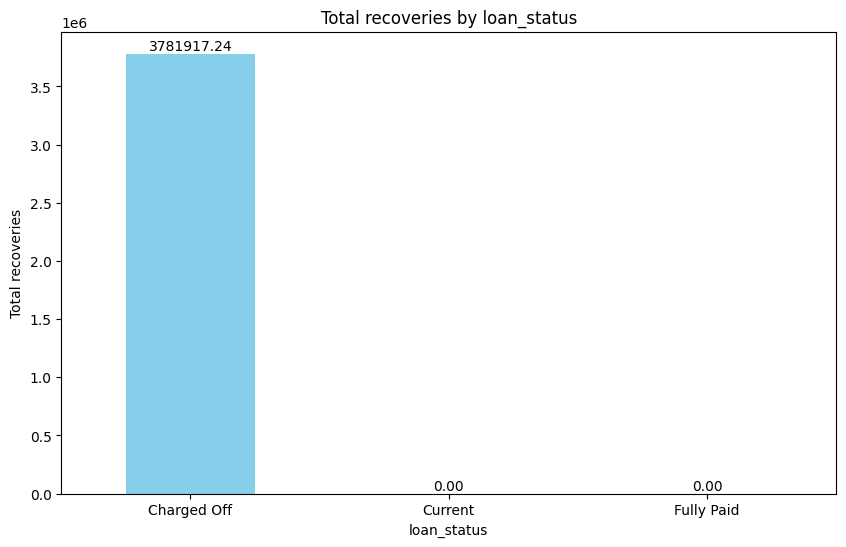

In [150]:
plt.figure(figsize=(10, 6))
total_recoveries = df.groupby('loan_status')['recoveries'].sum()
bars = total_recoveries.plot(kind='bar', color='skyblue')

# Add legend
for bar, value in zip(bars.patches, total_recoveries):
    bars.annotate(f'{value:.2f}', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.title('Total recoveries by loan_status')
plt.xlabel('loan_status')
plt.ylabel('Total recoveries')
plt.xticks(rotation=0)
plt.show()

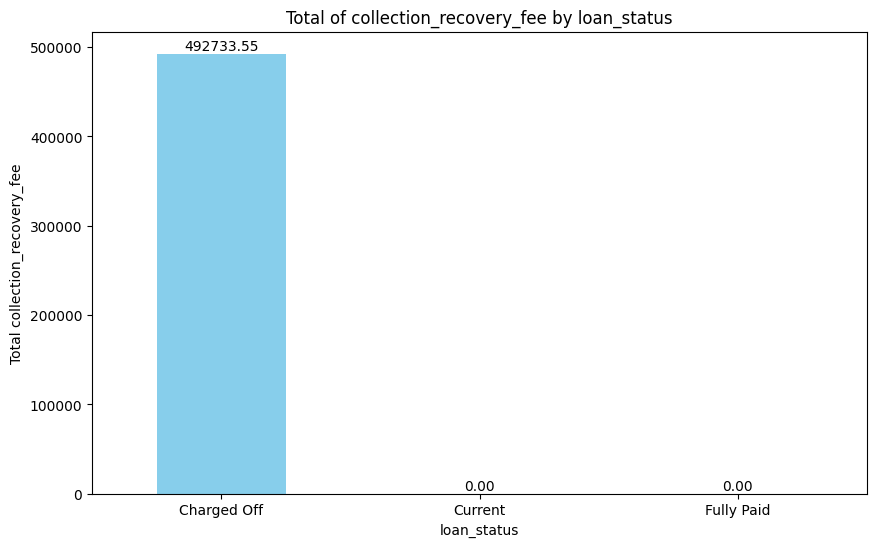

In [151]:
plt.figure(figsize=(10, 6))
total_recoveries = df.groupby('loan_status')['collection_recovery_fee'].sum()
bars = total_recoveries.plot(kind='bar', color='skyblue')

# Add legend
for bar, value in zip(bars.patches, total_recoveries):
    bars.annotate(f'{value:.2f}', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.title('Total of collection_recovery_fee by loan_status')
plt.xlabel('loan_status')
plt.ylabel('Total collection_recovery_fee')
plt.xticks(rotation=0)
plt.show()

**Initial Observations:**

We can see from the 2 bar charts above that the 2 features, `recoveries` and `collection_recovery_fee`, only have non-zero values for the `Charged Off` label. This makes sense because the meanings of these 2 features are, respectively: "Post Charge Off Gross Recovery" and "Post Charge Off Collection Fee."
From both their meanings and the charts, we can infer that these 2 features are only collected after a loan has been classified as `Charged Off`, meaning that just by knowing the values of these features, we can almost predict the label — leading to Label Leakage.

⇒ We must remove these variables because they suffer from Label Leakage, and in a real-world deployment, the values for these 2 features would not be available as inputs to the model.

In [152]:
df.drop(['recoveries', 'collection_recovery_fee'], axis=1, inplace=True)

**Remove meaningless features.**

In [153]:
print("# of Unique values of Categorical features:",
      df[cat_cols].nunique().sort_values().unique())

# of Unique values of Categorical features: [0 1 2 3 5 7]


**Initial Observations:**

We can see that some features contain only 0 or 1 unique value, which means they don't provide any useful information for the model. Therefore, we will remove them.

In [154]:
for column in df.columns:
    if df[column].nunique() < 2:
        df.drop([column], axis=1, inplace=True)

**Remove irrelevant features.**

In [155]:
df['url'].value_counts()

url
https://lendingclub.com/browse/loanDetail.action?loan_id=87023      1
https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1077430    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1077175    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1076863    1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=1071570    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1071795    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1072053    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1069639    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1075269    1
Name: count, Length: 39717, dtype: int64

In [156]:
df['desc'].value_counts()

desc
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             210
Debt Consolidation                                                                                                                                                                                                                                                                                                                                                

In [157]:
df['title'].value_counts()

title
Debt Consolidation            2184
Debt Consolidation Loan       1729
Personal Loan                  659
Consolidation                  517
debt consolidation             505
                              ... 
hardwood flooring business       1
DebtFix                          1
Credit card repayment loan       1
Brown Eyes Loan                  1
citicard fund                    1
Name: count, Length: 19615, dtype: int64

**Initial Observations:**

The features `desc` and `title` represent the loan application description and title, respectively. Both contain personal reasons for applying for a loan and are often written differently by each individual. Since we already have the `purpose` variable — which categorizes loan purposes in a standardized, more usable format — these 2 variables can be considered redundant and will be removed.

In [158]:
dropping_columns = ['url', 'desc', 'title']

for column in dropping_columns:
    df.drop([column], axis=1, inplace=True)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               39717 non-null  int64  
 1   funded_amnt             39717 non-null  int64  
 2   funded_amnt_inv         39717 non-null  float64
 3   term                    39717 non-null  object 
 4   int_rate                39717 non-null  object 
 5   installment             39717 non-null  float64
 6   grade                   39717 non-null  object 
 7   sub_grade               39717 non-null  object 
 8   emp_title               37258 non-null  object 
 9   emp_length              38642 non-null  object 
 10  home_ownership          39717 non-null  object 
 11  annual_inc              39717 non-null  float64
 12  verification_status     39717 non-null  object 
 13  issue_d                 39717 non-null  object 
 14  loan_status             39717 non-null

#### Data type conversion

**From object (string) to float.**

In [160]:
print("Data type:", df['int_rate'].dtype)
df['int_rate'].value_counts()

Data type: object


int_rate
10.99%    956
13.49%    826
11.49%    825
7.51%     787
7.88%     725
         ... 
17.34%      1
16.71%      1
16.15%      1
18.36%      1
14.67%      1
Name: count, Length: 371, dtype: int64

In [161]:
print("Data type:", df['revol_util'].dtype)
df['revol_util'].value_counts()

Data type: object


revol_util
0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
0.75%       1
2.64%       1
81.31%      1
26.33%      1
7.28%       1
Name: count, Length: 1089, dtype: int64

**Initial Observations:**

*  Both `int_rate` and `revol_util` contain numerical values but are stored as strings (object type), so we will convert them to float data type.


In [162]:
for column in ['int_rate', 'revol_util']:
    df[column] = df[column].str.rstrip('%').astype(float)
    df[column] /= 100

In [163]:
df['int_rate'].head()

0    0.1065
1    0.1527
2    0.1596
3    0.1349
4    0.1269
Name: int_rate, dtype: float64

In [164]:
df['revol_util'].head()

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64

**From object (string) to datetime.**

In [165]:
print("Data type:", df['issue_d'].dtype)
df['issue_d'].value_counts()

Data type: object


issue_d
Dec-11    2260
Nov-11    2223
Oct-11    2114
Sep-11    2063
Aug-11    1928
Jul-11    1870
Jun-11    1827
May-11    1689
Apr-11    1562
Mar-11    1443
Jan-11    1380
Feb-11    1297
Dec-10    1267
Oct-10    1132
Nov-10    1121
Jul-10    1119
Sep-10    1086
Aug-10    1078
Jun-10    1029
May-10     920
Apr-10     827
Mar-10     737
Feb-10     627
Nov-09     602
Dec-09     598
Jan-10     589
Oct-09     545
Sep-09     449
Aug-09     408
Jul-09     374
Jun-09     356
May-09     319
Apr-09     290
Mar-09     276
Feb-09     260
Jan-09     239
Mar-08     236
Dec-08     223
Nov-08     184
Feb-08     174
Jan-08     171
Apr-08     155
Oct-08      96
Dec-07      85
Jul-08      83
Aug-08      71
May-08      71
Jun-08      66
Oct-07      47
Nov-07      37
Aug-07      33
Sep-08      32
Jul-07      30
Sep-07      18
Jun-07       1
Name: count, dtype: int64

In [166]:
print("Data type:", df['last_pymnt_d'].dtype)
df['last_pymnt_d'].value_counts()

Data type: object


last_pymnt_d
May-16    1256
Mar-13    1026
Dec-14     945
May-13     907
Feb-13     869
          ... 
Jun-08      10
Nov-08      10
Mar-08       5
Jan-08       4
Feb-08       1
Name: count, Length: 101, dtype: int64

In [167]:
print("Data type:", df['last_credit_pull_d'].dtype)
df['last_credit_pull_d'].value_counts()

Data type: object


last_credit_pull_d
May-16    10308
Apr-16     2547
Mar-16     1123
Feb-13      843
Feb-16      736
          ...  
May-08        1
Jun-08        1
Jul-08        1
May-07        1
Jul-07        1
Name: count, Length: 106, dtype: int64

In [168]:
print("Data type:", df['earliest_cr_line'].dtype)
df['earliest_cr_line'].value_counts()

Data type: object


earliest_cr_line
Nov-98    370
Oct-99    366
Dec-98    348
Oct-00    346
Dec-97    329
         ... 
Jul-64      1
Apr-66      1
Dec-66      1
Oct-68      1
Oct-74      1
Name: count, Length: 526, dtype: int64

**Initial Observations:**

*  The features `issue_d`, `last_pymnt_d`, `last_credit_pull_d`, and `earliest_cr_line` all contain datetime values in the format MMM-YY, but are currently stored as strings (object type), so we will convert them to datetime data type.


In [169]:
for column in ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']:
    df[column] = pd.to_datetime(df[column], format='%b-%y')
    df[column] = df[column].dt.to_period('M')
    df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month

In [170]:
df[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']].head()

earliest_cr_line  issue_d last_pymnt_d last_credit_pull_d
0          1985-01  2011-12      2015-01            2016-05
1          1999-04  2011-12      2013-04            2013-09
2          2001-11  2011-12      2014-06            2016-05
3          1996-02  2011-12      2015-01            2016-04
4          1996-01  2011-12      2016-05            2016-05

In [171]:
date_df = pd.DataFrame()
for column in ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']:
    date_df[f'{column}_year'] = df[f'{column}_year']
    date_df[f'{column}_month'] = df[f'{column}_month']

date_df.head()

earliest_cr_line_year  earliest_cr_line_month  issue_d_year  issue_d_month  \
0                   1985                       1          2011             12   
1                   1999                       4          2011             12   
2                   2001                      11          2011             12   
3                   1996                       2          2011             12   
4                   1996                       1          2011             12   

   last_pymnt_d_year  last_pymnt_d_month  last_credit_pull_d_year  \
0               2015                   1                     2016   
1               2013                   4                     2013   
2               2014                   6                     2016   
3               2015                   1                     2016   
4               2016                   5                     2016   

   last_credit_pull_d_month  
0                         5  
1                         9  
2                         5  
3                         4  
4                         5

#### Processing categorical features

In [172]:
df['term'].value_counts()

term
36 months    29096
60 months    10621
Name: count, dtype: int64

In [173]:
df['verification_status'].value_counts()

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64

In [174]:
df['grade'].value_counts()

grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64

In [175]:
df['sub_grade'].value_counts()

sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64

In [176]:
df['emp_length'].value_counts()

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64

In [177]:
df['emp_title'].value_counts()

emp_title
US Army                             134
Bank of America                     109
IBM                                  66
AT&T                                 59
Kaiser Permanente                    56
                                   ... 
Connection Inspection                 1
Rich Products Corporation             1
Archdiocese of Galveston Houston      1
Osram Sylvania                        1
AIR RESOURCES BOARD                   1
Name: count, Length: 28820, dtype: int64

In [178]:
df['purpose'].value_counts()

purpose
debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: count, dtype: int64

In [179]:
df['home_ownership'].value_counts()

home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64

In [180]:
df['next_pymnt_d'].value_counts()

next_pymnt_d
Jun-16    1125
Jul-16      15
Name: count, dtype: int64

In [181]:
missing_values = df['next_pymnt_d'].isnull().sum()
print(f'# of missing values: {missing_values}/{df.shape[0]}')

# of missing values: 38577/39717


In [182]:
df['zip_code'].value_counts()

zip_code
100xx    597
945xx    545
112xx    516
606xx    503
070xx    473
        ... 
353xx      1
677xx      1
090xx      1
479xx      1
469xx      1
Name: count, Length: 823, dtype: int64

In [183]:
df['addr_state'].value_counts()

addr_state
CA    7099
NY    3812
FL    2866
TX    2727
NJ    1850
IL    1525
PA    1517
VA    1407
GA    1398
MA    1340
OH    1223
MD    1049
AZ     879
WA     840
CO     792
NC     788
CT     751
MI     720
MO     686
MN     615
NV     497
SC     472
WI     460
AL     452
OR     451
LA     436
KY     325
OK     299
KS     271
UT     258
AR     245
DC     214
RI     198
NM     189
WV     177
HI     174
NH     171
DE     114
MT      85
WY      83
AK      80
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64

**Initial Observations:**

*  The feature `term` has only 2 unique values, so we can encode it as 0 and 1.

*  The feature `verification_status` has 3 unique values, so we can apply one-hot encoding.

*  The features `grade` and `sub_grade` are both grading scales with different ranges. We can keep the `sub_grade` feature for label encoding (since integer values can represent an order, like a ranking) and remove the `grade` feature, as it conveys redundant information.

*  Similarly, the feature `emp_length` indicates the number of years of work experience, so we can apply label encoding (with 0 representing less than one year of experience).

*  The feature `emp_title` tells us the customer's occupation. This could provide a lot of information about the customer. However, it has 28,820 unique values, meaning we would need to group occupations into broader, more generalized categories to fit the model. This could take a long time and might not improve the model significantly, so we’ll choose to discard this feature to simplify the task for a project.

*  The `purpose` feature indicates the customer's reason for taking out a loan. However, this feature has quite a few unique values (13 in total), and the distribution among these values is highly imbalanced, with most of the data concentrated in the `debt_consolidation` category. There are several ways to handle this feature — one option is to apply one-hot encoding for each value — but that could complicate the computation. To keep things simpler for traditional machine learning models, we choose to reduce this feature to just 2 unique values: `debt_consolidation` (encoded as 1) and `not debt_consolidation` (encoded as 0).

*  Similarly, the feature `home_ownership` has 5 unique values, so we can reduce this feature to just 3 unique values: `RENT`, `MORTGAGE` and `OTHER_new` (which contains `OWN` ,`OTHER` and `NONE`), then apply one-hot encoding.

*  The feature `next_pymnt_d` indicates the next scheduled payment date of the customer. Therefore, we can encode the Null values as 'Unknown', representing an unscheduled payment. Afterward, we can reduce this feature to just 2 unique values: `scheduled payment` (encoded as 1) and `unscheduled payment` (encoded as 0).

*  The features `zip_code` and `addr_state` provide information about the applicant’s location. Therefore, we can group the zip codes into larger regions to encode the `addr_state` feature and discard the `zip_code` feature.

**Summary:**
*  Label encoding: `term`, `sub_grade`, `emp_length`, `purpose`,  `next_pymnt_d`

*  One-hot encoding: `verification_status`, `home_ownership`, `addr_state` (after grouping)

*  Remove: `grade`, `emp_title`, `zip_code`

**Label Encoding**

In [184]:
def label_encoder(dataframe, col):
    labelencoder = LabelEncoder()
    dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe

In [185]:
label_encode_columns = ['term', 'sub_grade', 'emp_length']

for col in label_encode_columns:
    df = label_encoder(df, col)

In [186]:
def process_purpose(value):
    if value == 'debt_consolidation':
        return 1
    else:
        return 0


df['purpose'] = df['purpose'].apply(process_purpose)
df['purpose'].value_counts().sort_index()

purpose
0    21076
1    18641
Name: count, dtype: int64

In [187]:
def process_next_pymnt_d(value):
    if value in ['Jun-16', 'Jul-16']:
        return 1
    else:
        return 0


df['next_pymnt_d'] = df['next_pymnt_d'].apply(process_next_pymnt_d)
df['next_pymnt_d'].value_counts().sort_index()

next_pymnt_d
0    38577
1     1140
Name: count, dtype: int64

Group the `addr_state` feature into larger regions to prepare for One-hot Encoding.

In [188]:
def process_addr_state(state):
    northeast = ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
    midwest = ['IA', 'IL', 'IN', 'KS', 'MI',
               'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
    south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA',
             'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
    west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID',
            'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Unknown'


df['region'] = df['addr_state'].apply(process_addr_state)

In [189]:
df['region'].value_counts()

region
South        13005
West         11433
Northeast     9696
Midwest       5583
Name: count, dtype: int64

**One-hot Encoding**

In [190]:
def process_home_ownership(ownership):
    if ownership in ['OWN', 'OTHER', 'NONE']:
        return 'OTHER_new'
    else:
        return ownership


df['home_ownership'] = df['home_ownership'].apply(process_home_ownership)

In [191]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns=categorical_cols,
                               drop_first=drop_first,
                               dtype=int)
    return dataframe

In [192]:
onehot_encode_columns = ['verification_status', 'home_ownership', 'region']

df = one_hot_encoder(df, onehot_encode_columns)

In [193]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment grade  \
0       5000         5000           4975.0     0    0.1065       162.87     B   
1       2500         2500           2500.0     1    0.1527        59.83     C   
2       2400         2400           2400.0     0    0.1596        84.33     C   
3      10000        10000          10000.0     0    0.1349       339.31     C   
4       3000         3000           3000.0     1    0.1269        67.79     B   

   sub_grade                 emp_title  emp_length  ...  \
0          6                       NaN           1  ...   
1         13                     Ryder          10  ...   
2         14                       NaN           1  ...   
3         10       AIR RESOURCES BOARD           1  ...   
4          9  University Medical Group           0  ...   

   verification_status_Not Verified verification_status_Source Verified  \
0                                 0                                   0   
1                                 0                                   1   
2                                 1                                   0   
3                                 0                                   1   
4                                 0                                   1   

  verification_status_Verified  home_ownership_MORTGAGE  \
0                            1                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   

  home_ownership_OTHER_new home_ownership_RENT  region_Midwest  \
0                        0                   1               0   
1                        0                   1               0   
2                        0                   1               1   
3                        0                   1               0   
4                        0                   1               0   

   region_Northeast region_South  region_West  
0                 0            0            1  
1                 0            1            0  
2                 0            0            0  
3                 0            0            1  
4                 0            0            1  

[5 rows x 57 columns]

**Remove unused features**

In [194]:
dropping_columns = ['grade', 'emp_title', 'zip_code', 'addr_state']

for column in dropping_columns:
    df.drop([column], axis=1, inplace=True)

#### Handle Missing values

In [195]:
def check_missing_values(dataframe):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(' MISSING VALUES '.center(70, '-'))
    print(dataframe.isnull().sum())


check_missing_values(df)

------------------------------- SHAPE --------------------------------
Rows: 39717
Columns: 53
--------------------------- MISSING VALUES ---------------------------
loan_amnt                                  0
funded_amnt                                0
funded_amnt_inv                            0
term                                       0
int_rate                                   0
installment                                0
sub_grade                                  0
emp_length                                 0
annual_inc                                 0
issue_d                                    0
loan_status                                0
purpose                                    0
dti                                        0
delinq_2yrs                                0
earliest_cr_line                           0
inq_last_6mths                             0
mths_since_last_delinq                 25682
mths_since_last_record                 36931
open_acc                

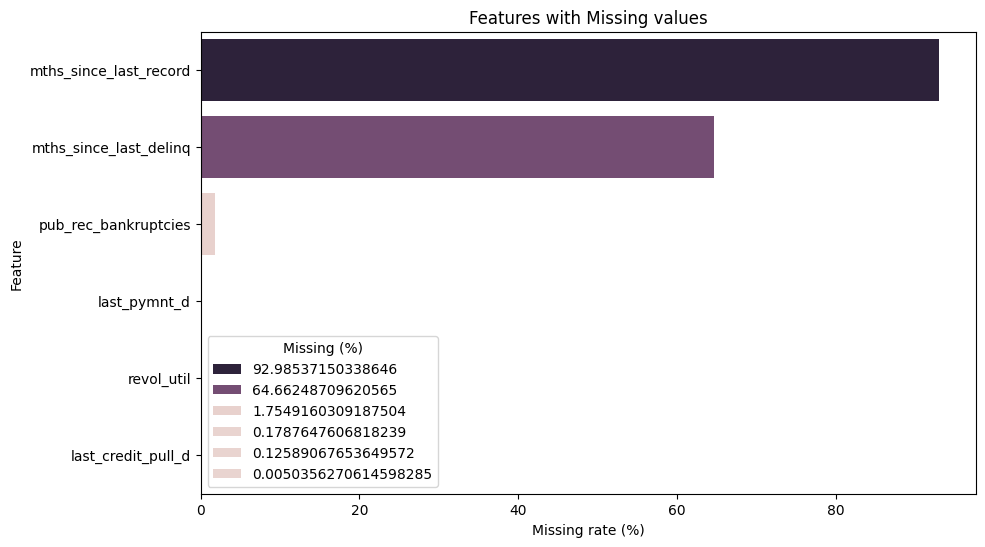

In [196]:
# Compute missing values percentage
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_df = missing_percent[missing_percent > 0].to_frame().reset_index()
missing_df.columns = ['Feature', 'Missing (%)']

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing (%)', y='Feature', hue='Missing (%)')

# Reverse the legend order to match the bar order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title='Missing (%)')

plt.title('Features with Missing values')
plt.xlabel('Missing rate (%)')
plt.ylabel('Feature')
plt.show()

**Initial Observations:**

*  The features `mths_since_last_delinq` and `mths_since_last_record` have **64.66%** and **92.99%** missing data, respectively. Additionally, since both are numerical features, we cannot handle them the same way we did with categorical features earlier. Therefore, we can choose to remove these features.

*  The features `last_credit_pull_d`, `revol_util`, `last_pymnt_d`, and `pub_rec_bankruptcies` have relatively few missing values — approximately ~0%, 0.13%, 0.18% and 1.75%, respectively — so we can drop those observations without significantly affecting the overall data distribution.

In [197]:
df.drop(['mths_since_last_delinq', 'mths_since_last_record'], axis=1, inplace=True)

In [198]:
df = df.dropna()

In [199]:
check_missing_values(df)

------------------------------- SHAPE --------------------------------
Rows: 38902
Columns: 51
--------------------------- MISSING VALUES ---------------------------
loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
term                                   0
int_rate                               0
installment                            0
sub_grade                              0
emp_length                             0
annual_inc                             0
issue_d                                0
loan_status                            0
purpose                                0
dti                                    0
delinq_2yrs                            0
earliest_cr_line                       0
inq_last_6mths                         0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc     

In [200]:
print(' DUPLICATED VALUES '.center(70, '-'))
print(df.duplicated().sum())

------------------------- DUPLICATED VALUES --------------------------
0


**Initial Observations:**

The dataset no longer contains any missing values or duplicated observations. In addition, irrelevant features have been removed, categorical and datetime features have been processed, and outliers have been handled.

⇒ We can now begin using the dataset for analysis and model training.

## 3. Exploratory Data Analysis (EDA)

#### Check the distribution of the target feature - `loan_status`

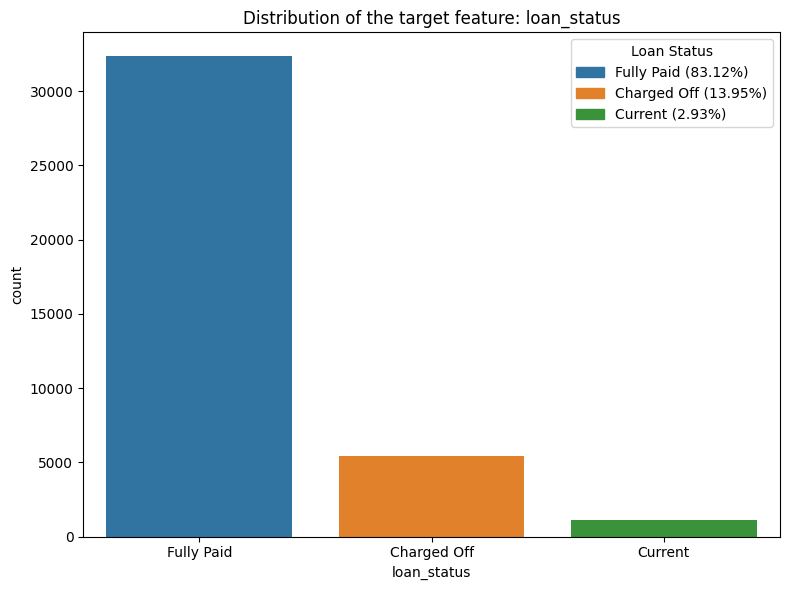

In [201]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='loan_status', hue='loan_status', legend=False)

# Create handles (use the bars' colors) and labels
target_classes = df['loan_status'].unique()
percentages = df['loan_status'].value_counts(
    normalize=True).loc[target_classes] * 100
handles = [plt.Rectangle((0, 0), 1, 1, color=bar.get_facecolor())
           for bar in ax.patches]
labels = [f"{cls} ({percentages[cls]:.2f}%)" for cls in target_classes]

plt.legend(handles, labels, title='Loan Status')
plt.title('Distribution of the target feature: loan_status')
plt.tight_layout()
plt.show()

**Initial Observations:**

The target feature `loan_status` has 3 values:

*  `Fully Paid`: The borrower has repaid the full loan amount, including principal and interest, according to the loan terms.

*  `Current`: The borrower is currently making payments on time.

*  `Charged Off`: The borrower has defaulted for an extended period, and the lender has written off the debt as uncollectible.

⇒ Since we aim to build a model that classifies whether a customer should or should not be approved for a loan, we will group those with good repayment behavior — `Fully Paid` and `Current` — into the `Accept` group (i.e., eligible for a loan), and those with poor repayment behavior — `Charged Off` — into the `Reject` group (i.e., ineligible for a loan).

⇒ We will encode `Accept` as 1 and `Reject` as 0.

**Regarding imbalanced data:**
There is an imbalance between the classes, which could cause one class to dominate the model. However, we will first try building the models to see if this imbalance causes any performance issues. If it does, we’ll apply techniques to address it. If the model performs well without signs of class dominance, we can skip handling the imbalance.

In [202]:
df['loan_status'] = df['loan_status'].apply(
    lambda x: 1 if (x == 'Fully Paid' or x == 'Current') else 0)

In [203]:
df['loan_status'].value_counts()

loan_status
1    33477
0     5425
Name: count, dtype: int64

#### Correlations between features and the target variable - `loan_status`

In [204]:
period_columns = df.select_dtypes(include=['period[M]']).columns
X = df.drop(columns=['loan_status'] + list(period_columns))
y = df['loan_status']

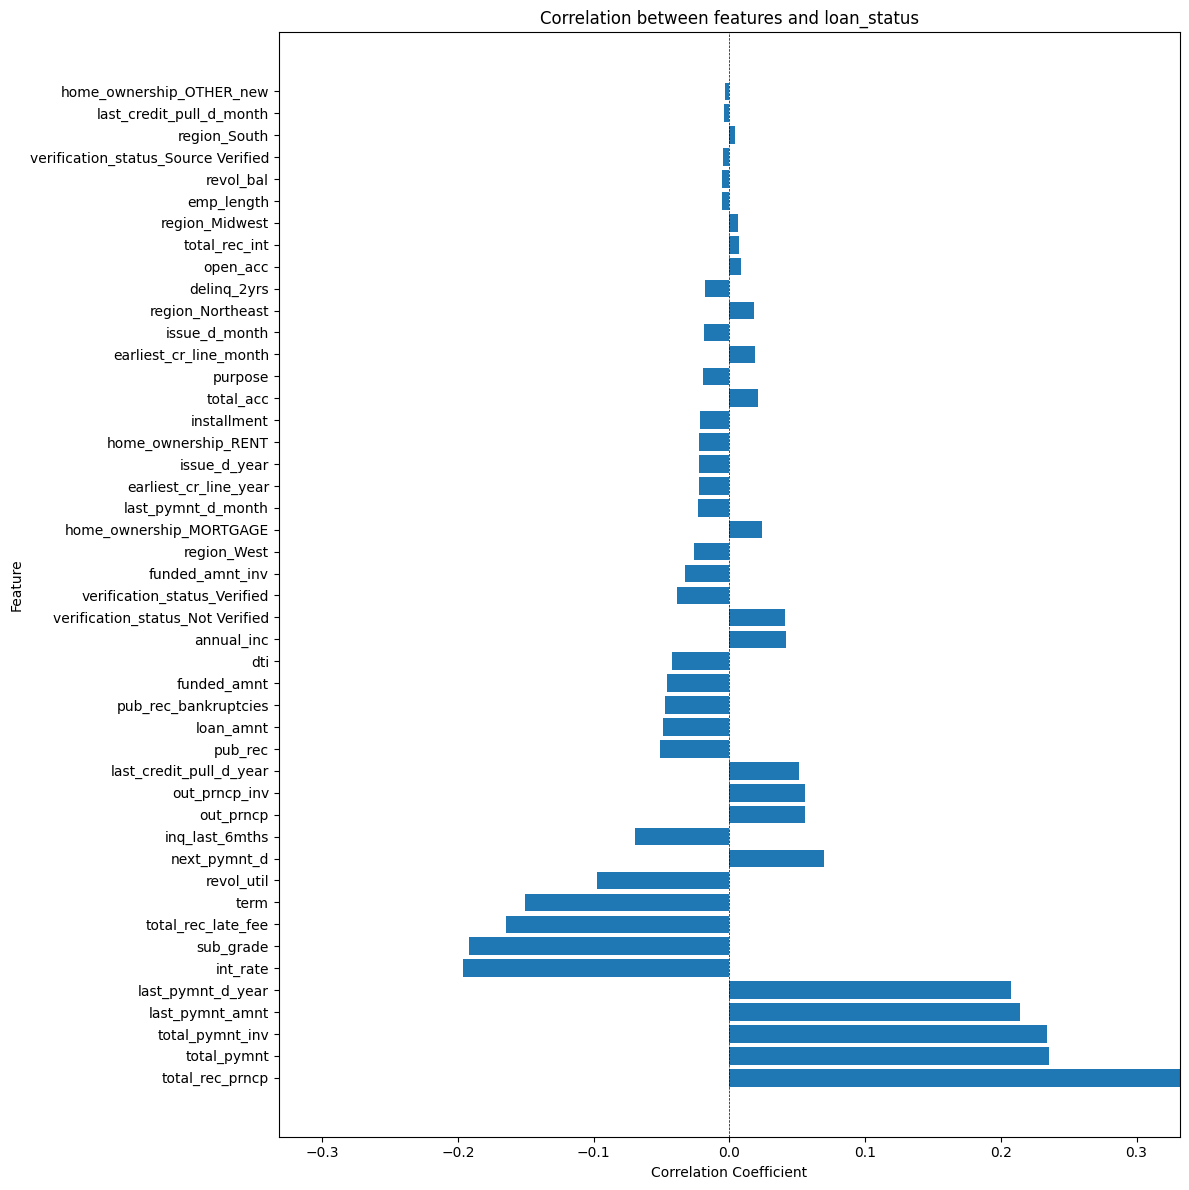

In [205]:
correlation_matrix = df.drop(columns=list(period_columns)).corr()
correlation_coef = correlation_matrix['loan_status'].drop('loan_status')
features = X.columns

loan_status_correlations = pd.DataFrame({
    'Feature': features,
    'Correlation': correlation_coef
})

# Select correlations with 'loan_status'
loan_status_correlations['Abs Correlation'] = np.abs(
    loan_status_correlations['Correlation'])
loan_status_correlations_sorted = loan_status_correlations.sort_values(
    by='Abs Correlation', ascending=False)

# Plot the correlations
plt.figure(figsize=(12, 12))
plt.barh(loan_status_correlations_sorted['Feature'],
         loan_status_correlations_sorted['Correlation'])
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.title('Correlation between features and loan_status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')

# Set symmetric x-axis limits
max_corr = loan_status_correlations_sorted['Correlation'].abs().max()
plt.xlim(-max_corr, max_corr)

plt.tight_layout()
plt.show()

**Initial Observations:**

*  There is no feature that has a strong correlation (>0.5) with the target variable `loan_status`.
*  Although there are 46 features, only about 10 features show a notable correlation with the target variable `loan_status`, including: `total_rec_prncp`, `total_pymnt`, `total_pymnt_inv`, `last_pymnt_amnt`, `last_pymnt_d_year`, `int_rate`, `sub_grade`, `total_rec_late_fee`, `term`, `revol_util`.

⇒ We can predict that models might achieve similar performance using only these approximately 10 features (or slightly more or fewer) compared to using all 46 features. Based on this, it may be possible to design a simpler model with nearly equivalent effectiveness.

#### Using PCA to visualize the distribution of the dataset

In [206]:
numerical_features = X.select_dtypes(include=np.number)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_features)

In [207]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['loan_status'] = df['loan_status'].values

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='loan_status',
                    title='PCA 3D Scatter Plot of Loan Status Classes')

fig.show()

#### Univariate Analysis

In [208]:
# Sort out period and object features
numeric_df = df.select_dtypes(include=[np.number])

numeric_df = numeric_df.drop(columns=['loan_status'])

cat_cols, num_cols, cat_but_car = grab_col_names(
    numeric_df, cat_th=5, car_th=10)

# of Observations: 38902
# of Features: 46
# of Categorical Columns: 14	(Numerical but categorical: 14)
# of Numerical Columns: 32
# of Categorical but cardinal: 0


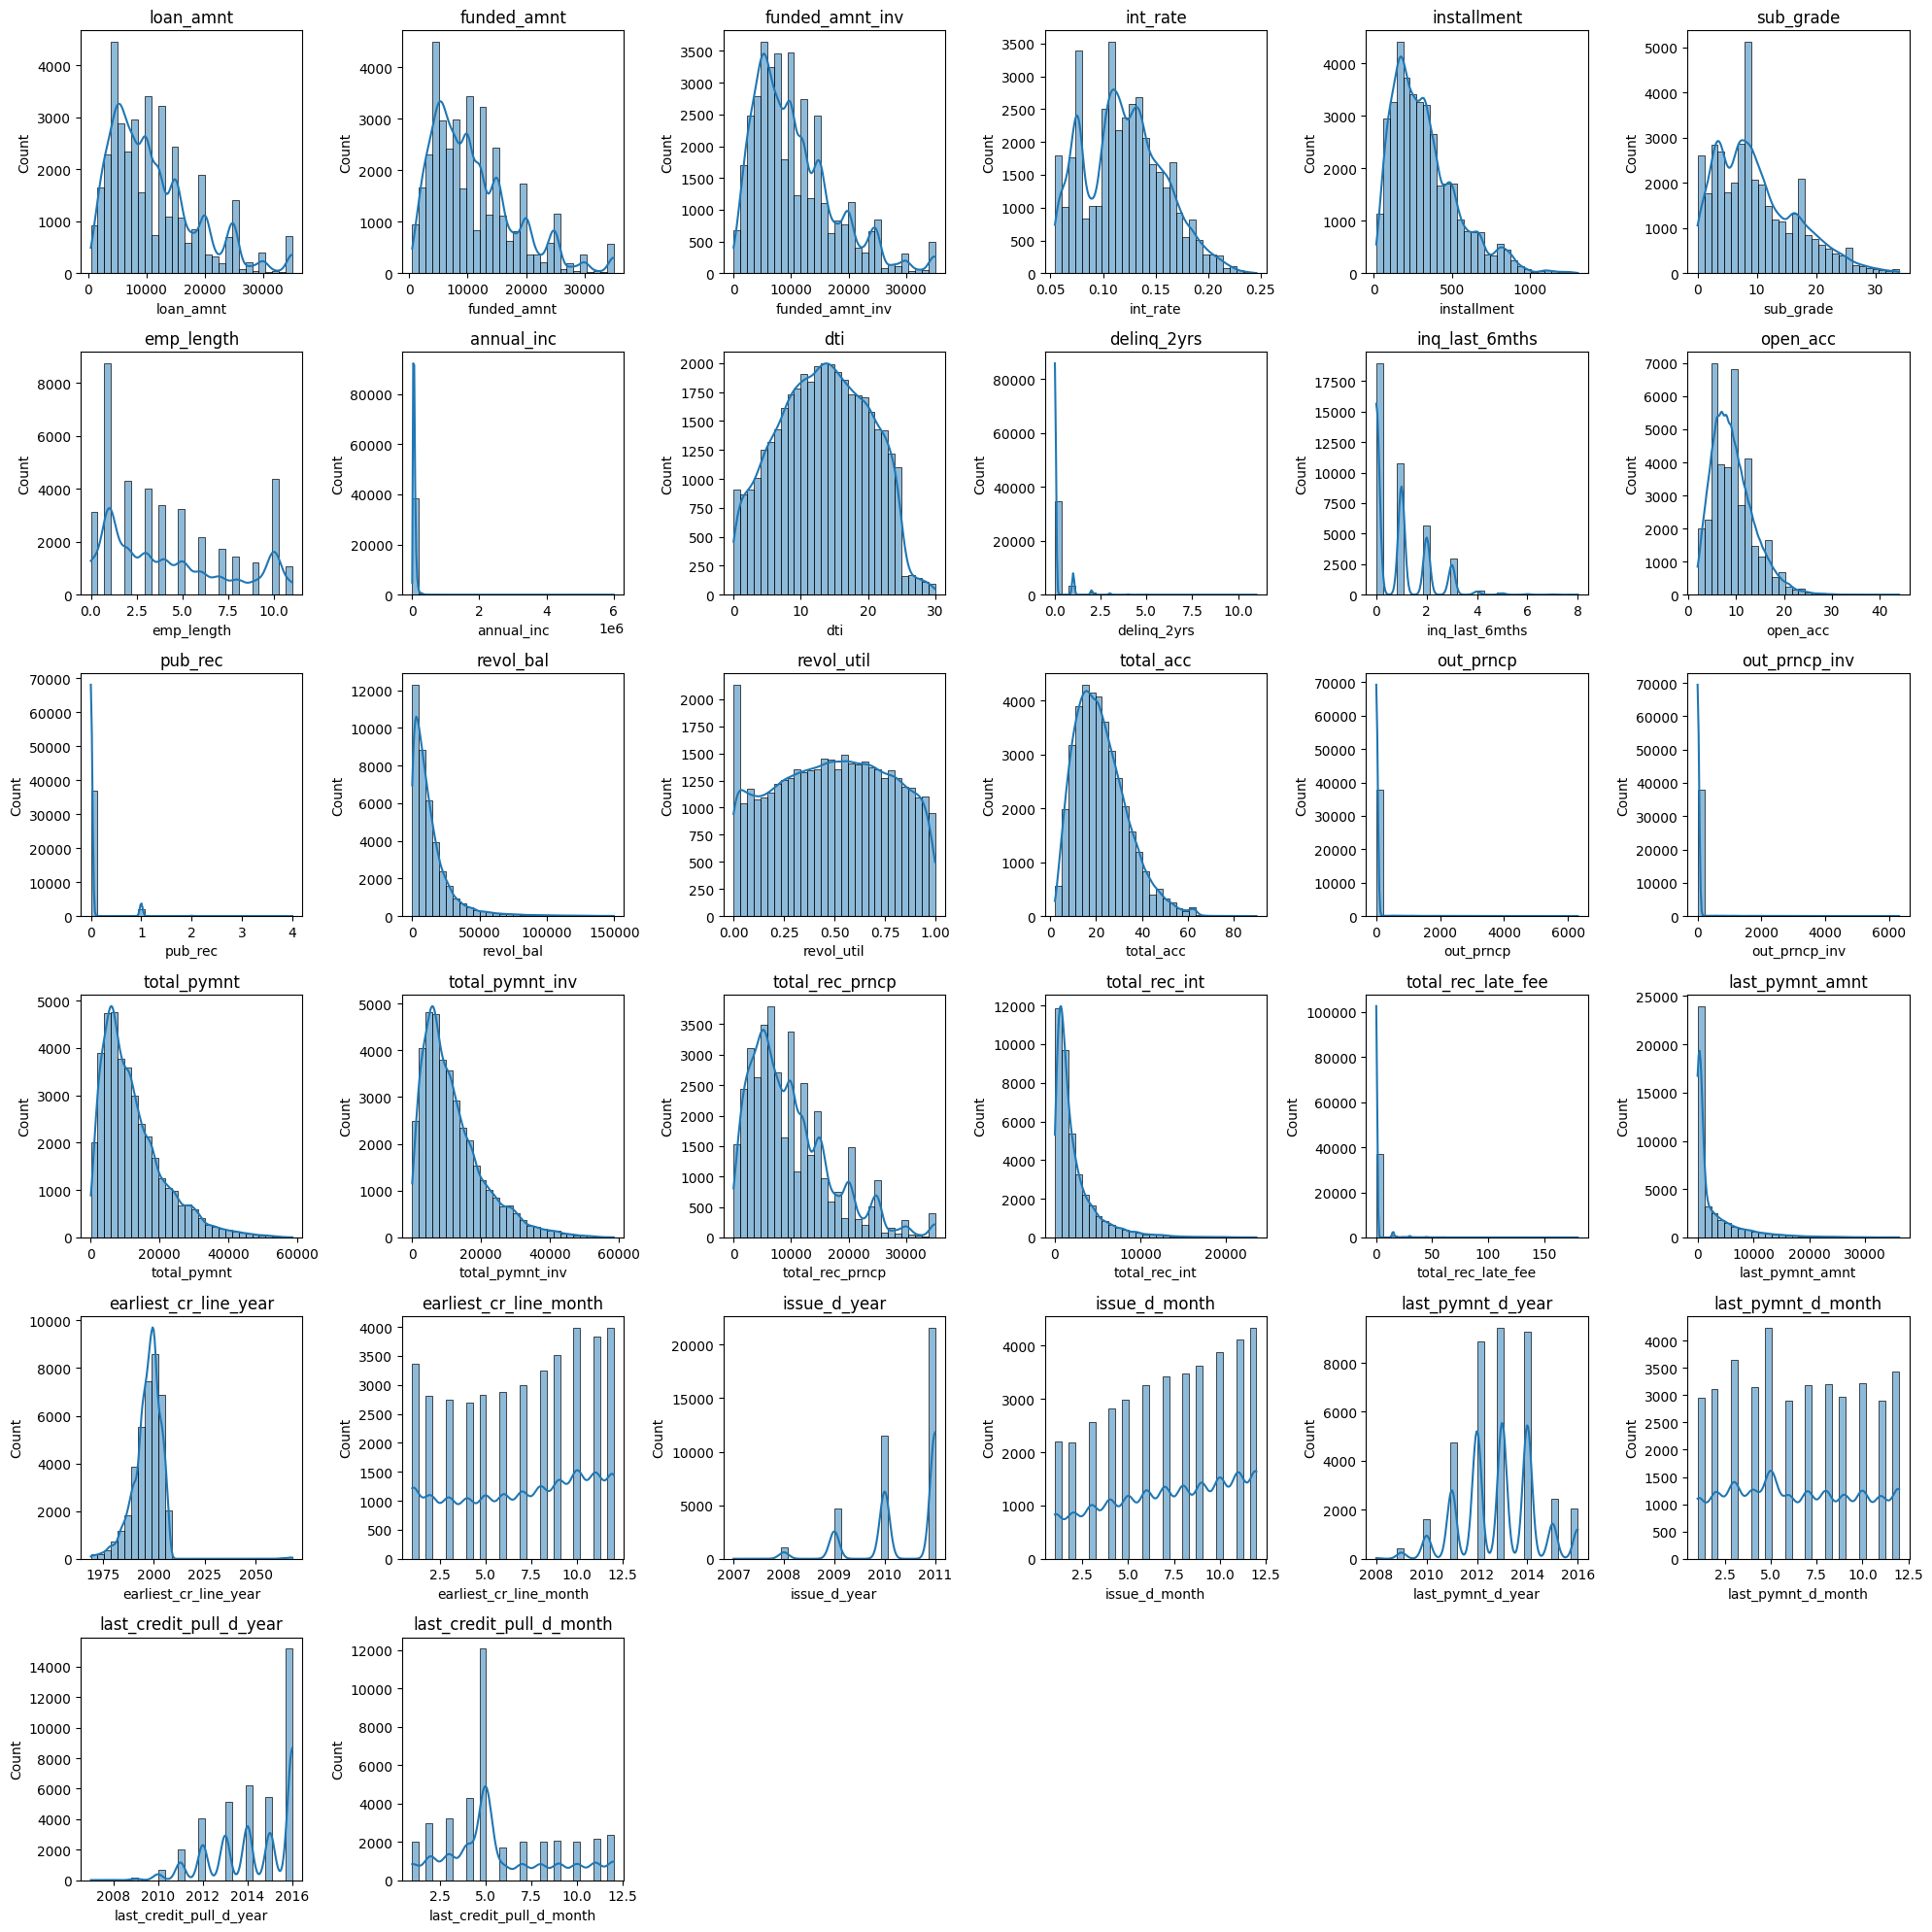

In [209]:
def plot_distributions(df, columns, cols=3, figsize=(20, 20), kind='hist'):
    rows = -(-len(columns) // cols)  # ceiling division
    plt.figure(figsize=figsize)
    for i, col in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        if kind == 'hist':
            sns.histplot(df[col], kde=True, bins=30)
        elif kind == 'box':
            sns.boxplot(x=df[col])
        elif kind == 'count':
            sns.countplot(x=df[col], order=df[col].value_counts().index)
            plt.xticks(rotation=90)
        plt.title(col)
    plt.tight_layout()
    plt.show()


plot_distributions(numeric_df, num_cols, kind='hist', cols=6, figsize=(20, 20))

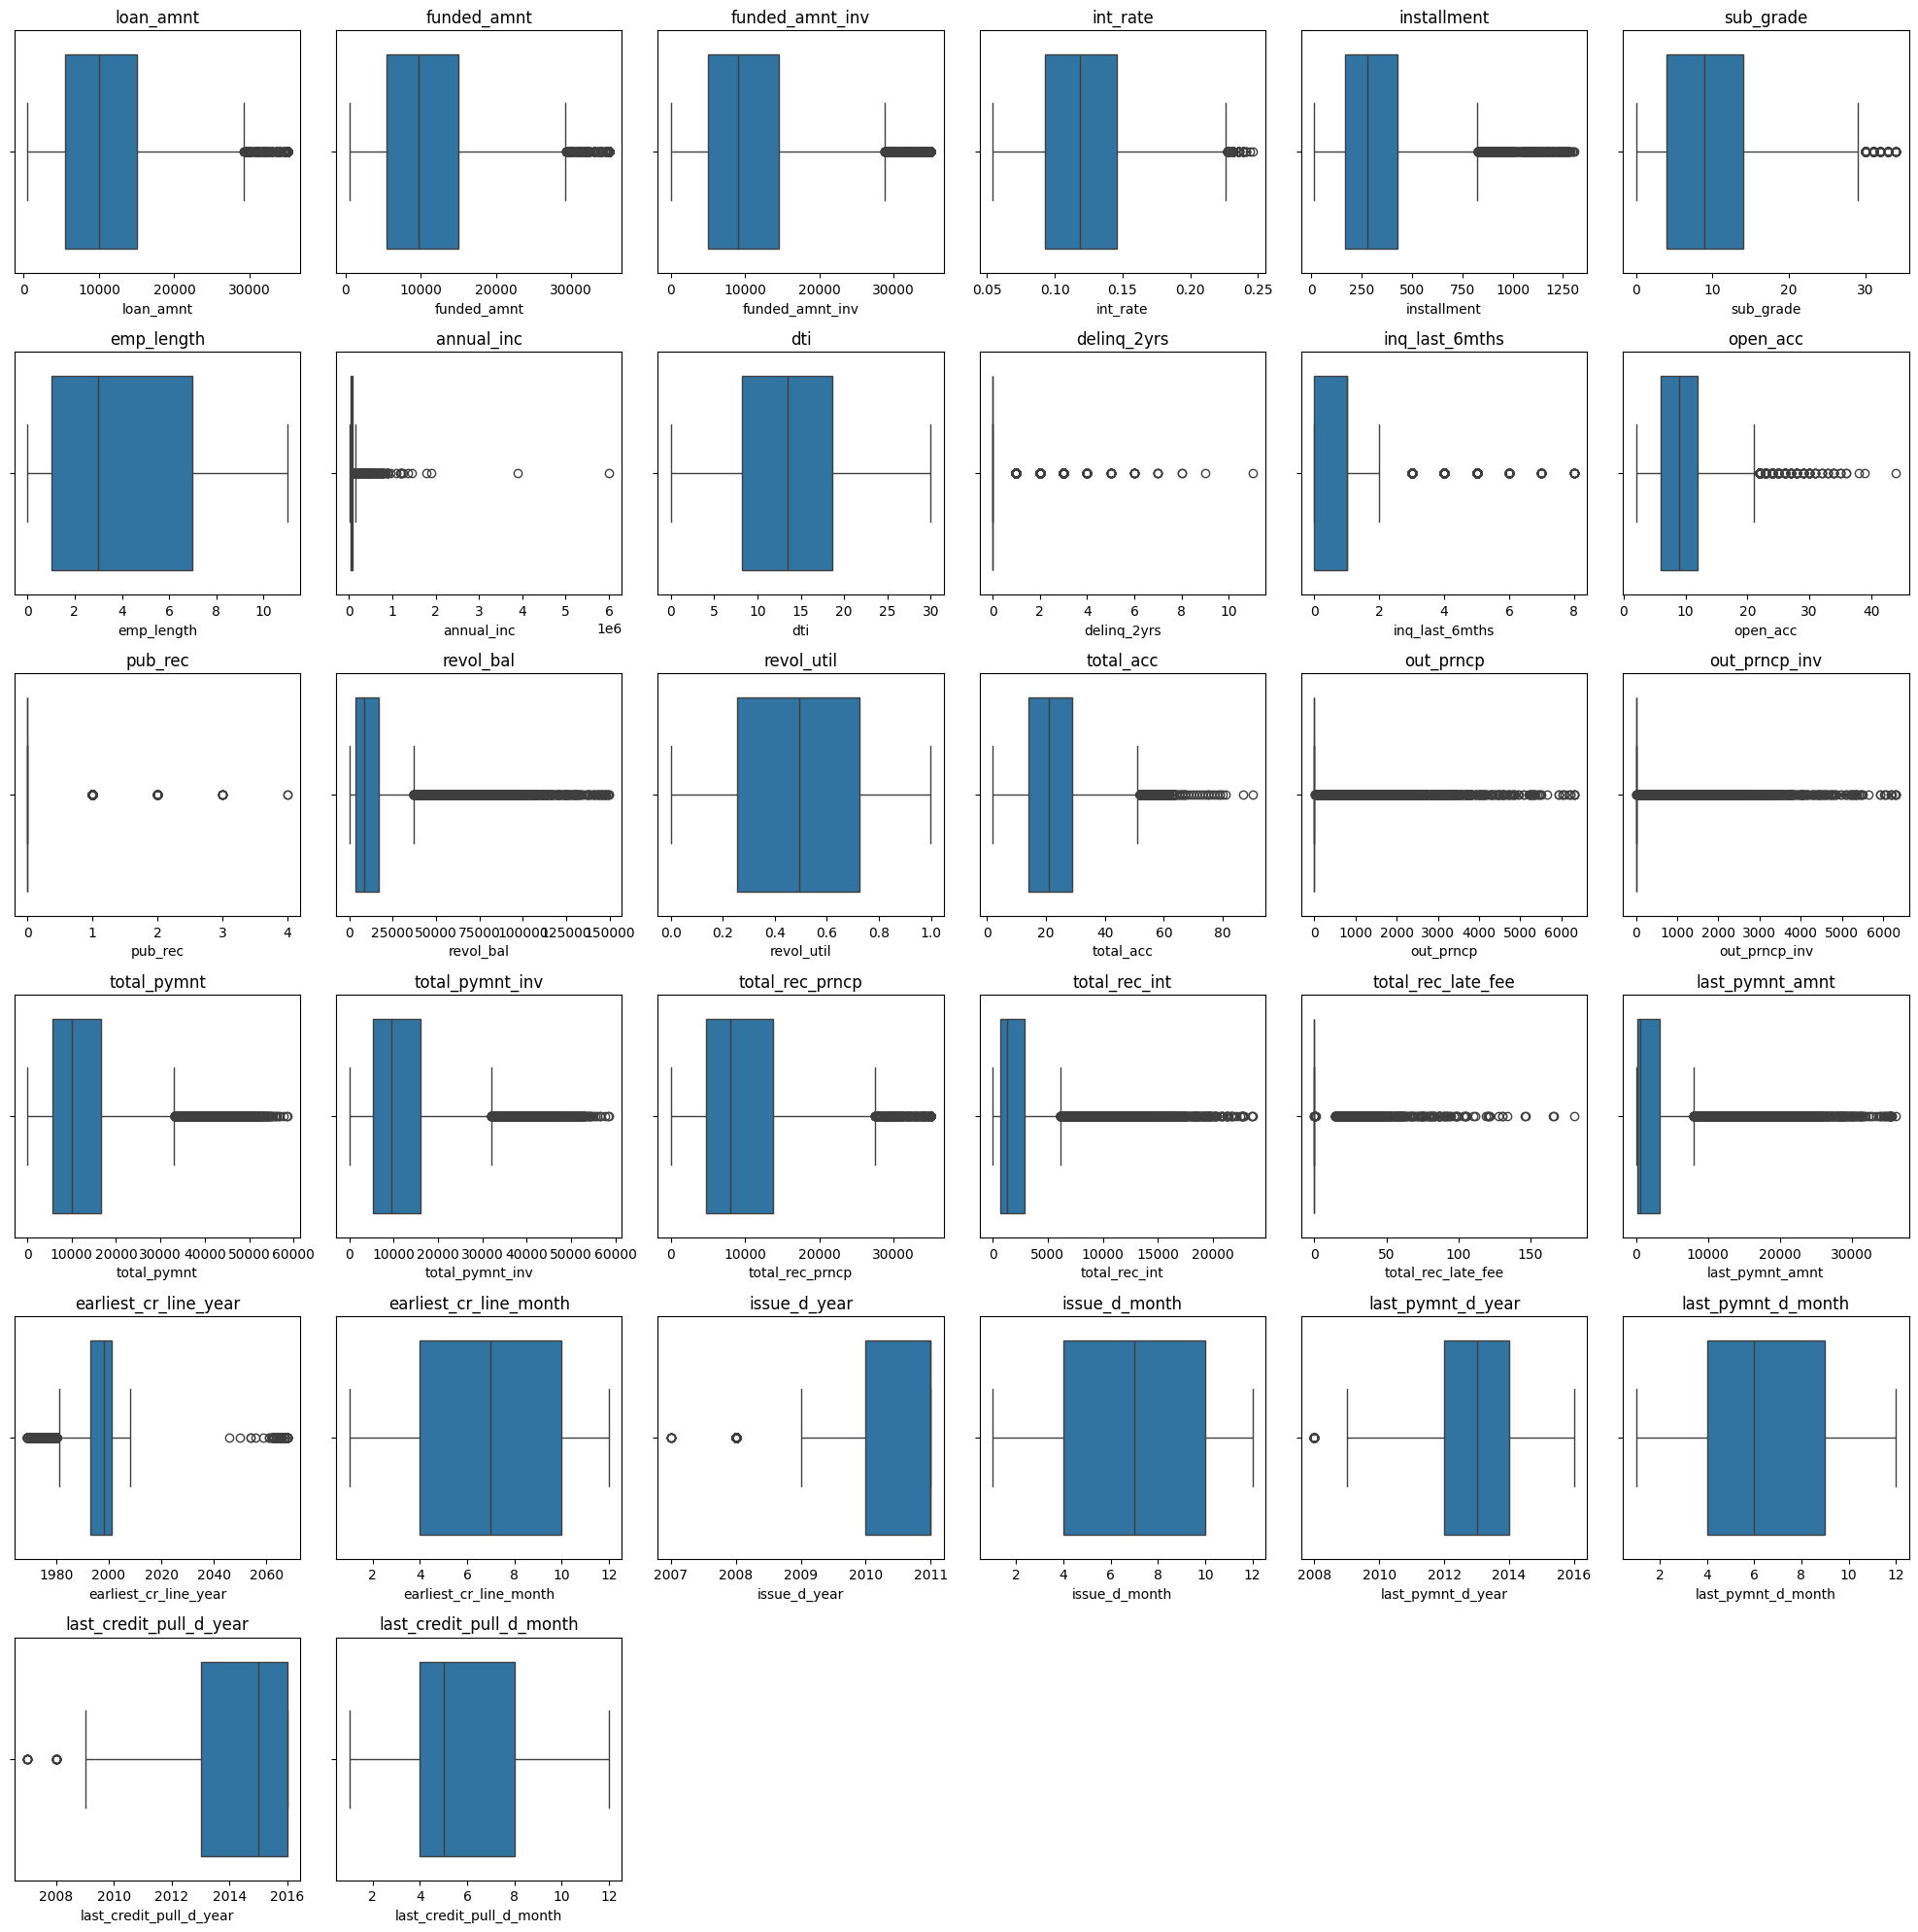

In [210]:
plot_distributions(numeric_df, num_cols, kind='box', cols=6, figsize=(20, 20))

**Initial Observations:**

*  Many features are heavily skewed, which is a sign that there may be outliers in the dataset. However, we cannot rely solely on the individual distribution of each feature to remove outliers using methods like IQR or Z-score, as these approaches do not take into account interactions between multiple features. Removing outliers this way may unintentionally eliminate meaningful outliers relevant to the problem, or even remove too many observations, leading to significant data loss.

*  Because we don't know which outliers are meaningful and should be kept, and which ones should actually be removed, we will build baseline models to compare the model performance before and after outlier processing — whichever model performs better will guide our decision.

⇒ Therefore, we need an **outlier detection method** that considers the combination of multiple features, and **baseline models** trained on the dataset before any outlier processing.

#### Bivariate/Multivariate Analysis

**Remove variables with the Period data type because the libraries used for analysis do not support processing this data type.**

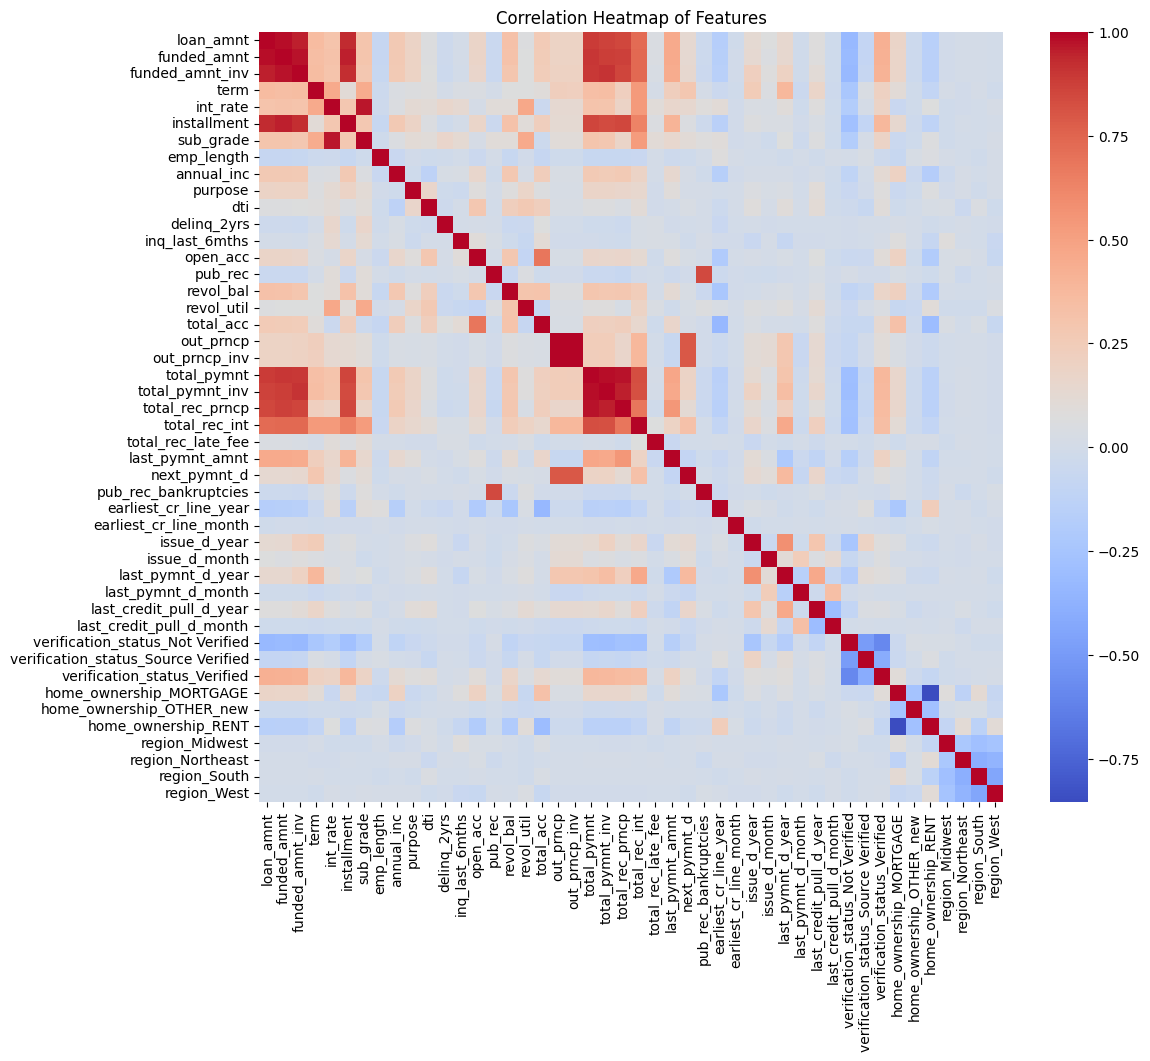

In [211]:
period_columns = df.select_dtypes(include=['period[M]']).columns
X = df.drop(columns=['loan_status'] + list(period_columns))
correlation_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

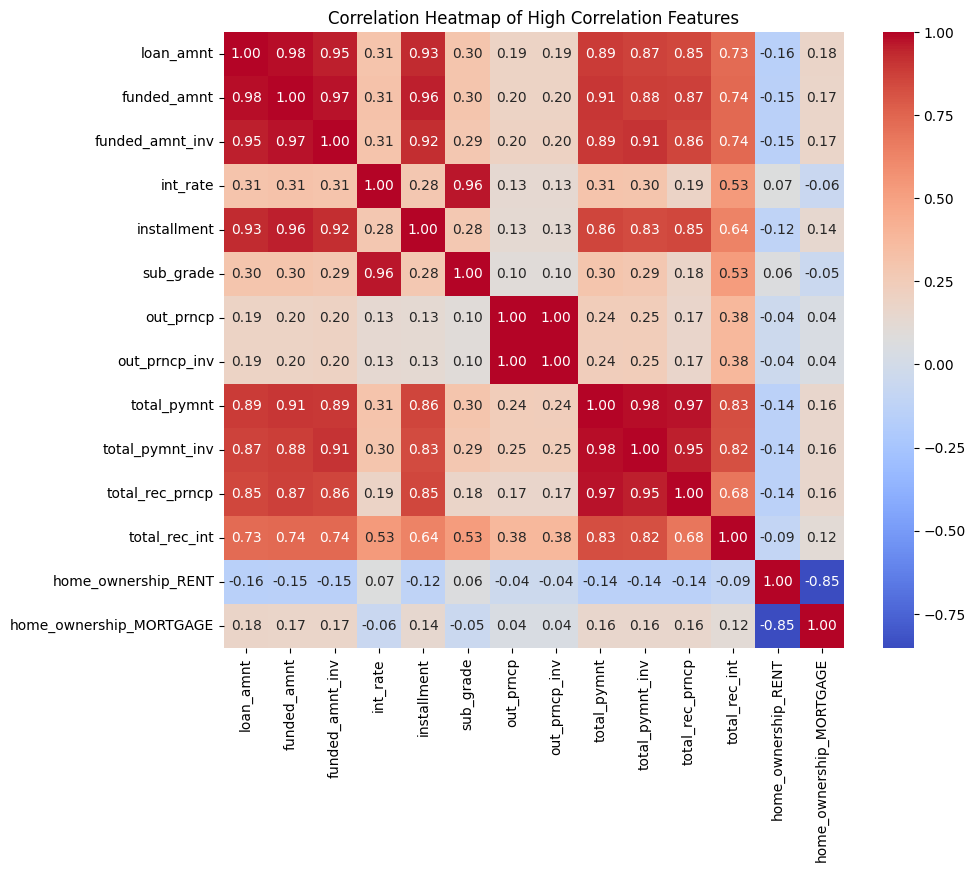

In [212]:
high_corr_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'sub_grade',
                      'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'home_ownership_RENT', 'home_ownership_MORTGAGE']
correlation_matrix = numeric_df[high_corr_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of High Correlation Features')
plt.show()

**Initial Observations:**

Many features have relatively high correlations with each other, such as `loan_amnt` with `funded_amnt` or `funded_amnt` with `funded_amnt_inv`. However, only linear models like Logistic Regression are affected by high correlations. They do not impact predictive performance but can reduce the explanability of the model.

⇒ We will observe the model results first and then decide whether it is necessary (or worthwhile) to handle these highly correlated variables.

#### Building Baseline Models for comparision

In [213]:
baseline_df = df.copy()

baseline_X = baseline_df.drop(columns=['loan_status'] + list(period_columns))
baseline_y = baseline_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
    baseline_X, baseline_y, train_size=0.8, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.8, random_state=0)

X_train.shape, X_valid.shape, X_test.shape

((24896, 46), (6225, 46), (7781, 46))

**Logistic Regression**

In [214]:
start_time = time.time()

lr_model = LogisticRegression(solver='saga', max_iter=10000)
lr_model.fit(X_train, y_train)

end_time = time.time()
lr_train_time = end_time - start_time

print(f"Training time: {lr_train_time:.2f} seconds")
y_pred_lr = lr_model.predict(X_test)

Training time: 61.15 seconds


In [215]:
print("AUC-ROC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr))
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

AUC-ROC (Logistic Regression): 0.8997748085872993
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      1120
           1       0.97      1.00      0.98      6661

    accuracy                           0.97      7781
   macro avg       0.98      0.90      0.94      7781
weighted avg       0.97      0.97      0.97      7781



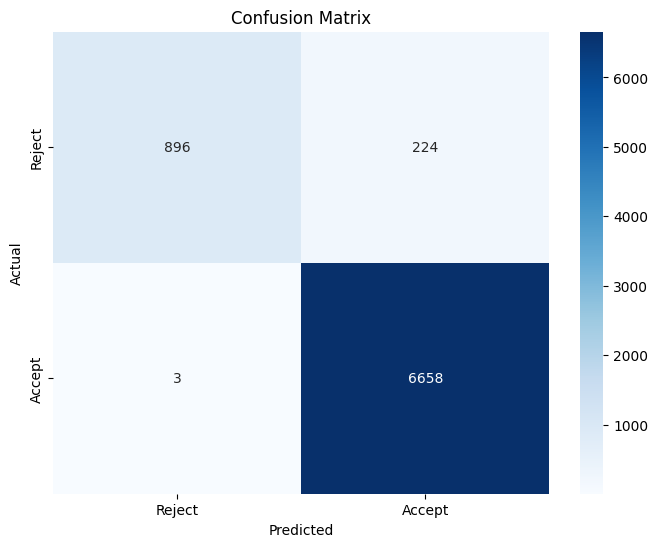

In [216]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Decision Tree**

In [217]:
start_time = time.time()

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

end_time = time.time()
dt_train_time = end_time - start_time

print(f"Training time: {dt_train_time:.2f} seconds")
y_pred_dt = dt_model.predict(X_test)

Training time: 0.59 seconds


In [218]:
print("AUC-ROC (Decision Tree):", roc_auc_score(y_test, y_pred_dt))
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

AUC-ROC (Decision Tree): 0.9689356488729706
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1120
           1       0.99      0.99      0.99      6661

    accuracy                           0.98      7781
   macro avg       0.97      0.97      0.97      7781
weighted avg       0.98      0.98      0.98      7781



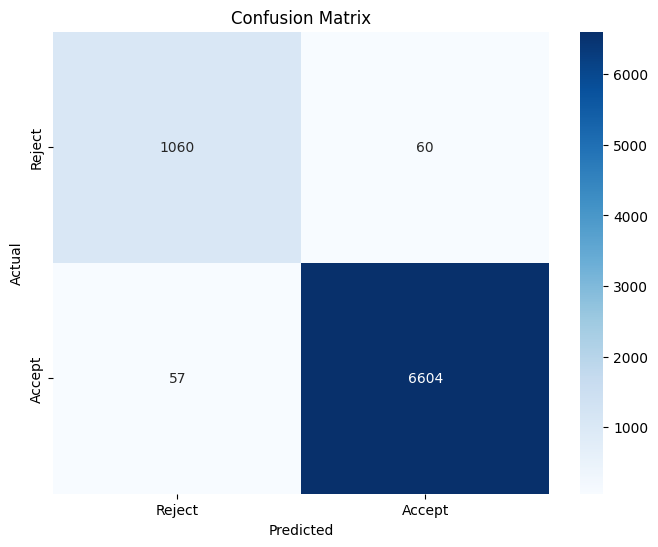

In [219]:
conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**LightGBM**

In [220]:
X_train_gbm = X_train
X_valid_gbm = X_valid
X_test_gbm = X_test

cat_cols, num_cols, cat_but_car = grab_col_names(
    baseline_X, cat_th=5, car_th=10)
categorical_features = cat_cols.copy()
categorical_features.append('emp_length')

for col in categorical_features:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in categorical_features:
    X_valid_gbm[col] = X_valid_gbm[col].astype('category')

for col in categorical_features:
    X_test_gbm[col] = X_test_gbm[col].astype('category')

lgb_train = lgb.Dataset(
    X_train_gbm, y_train,
    categorical_feature=categorical_features,
    free_raw_data=False,
)

lgb_valid = lgb.Dataset(
    X_valid_gbm, y_valid,
    categorical_feature=categorical_features,
    free_raw_data=False,
    reference=lgb_train,
)

params = {
    "objective": "binary",
    "num_iterations": 3000,
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "max_depth": 4,
    "num_threads": 4,
    "tree_learner": "serial",
    # "lambda_l2": 0.05,
    # "path_smooth": 128,
    "early_stopping_round": 200,
    "feature_pre_filter": False,
    "first_metric_only": True,
    "is_unbalance": False,
}

# of Observations: 38902
# of Features: 46
# of Categorical Columns: 14	(Numerical but categorical: 14)
# of Numerical Columns: 32
# of Categorical but cardinal: 0


In [221]:
start_time = time.time()

gbm_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(100, first_metric_only=True),
        lgb.log_evaluation(50, show_stdv=True)
    ]
)

end_time = time.time()
gbm_train_time = end_time - start_time

print(f"Training time: {gbm_train_time:.2f} seconds")
y_pred = gbm_model.predict(X_test_gbm)
y_pred_gbm = (y_pred > 0.5).astype(int)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21450, number of negative: 3446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 24896, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.861584 -> initscore=1.828511
[LightGBM] [Info] Start training from score 1.828511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
print("AUC-ROC (Gradient Boosting/LightGBM):",
      roc_auc_score(y_test, y_pred_gbm))
print("Gradient Boosting/LightGBM - Classification Report:")
print(classification_report(y_test, y_pred_gbm))

AUC-ROC (Gradient Boosting/LightGBM): 0.9909963647671949
Gradient Boosting/LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1120
           1       1.00      1.00      1.00      6661

    accuracy                           1.00      7781
   macro avg       1.00      0.99      0.99      7781
weighted avg       1.00      1.00      1.00      7781



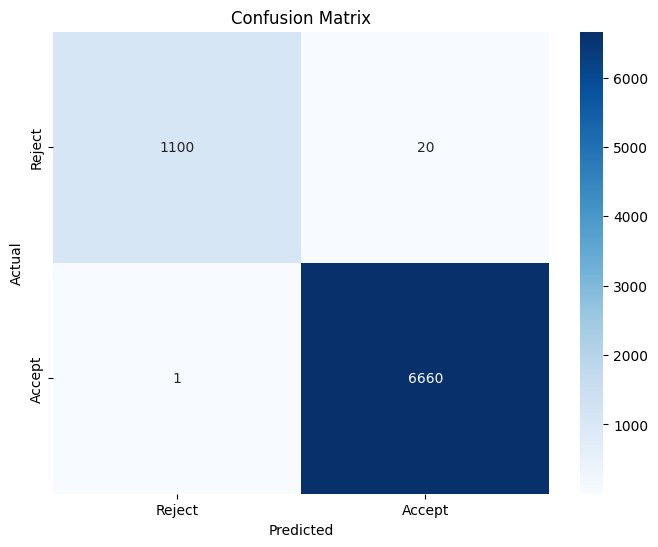

In [223]:
conf_matrix = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Comparison**

In [224]:
metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_gbm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_pred_gbm),
    ],
    'Train Time': [
        lr_train_time,
        dt_train_time,
        gbm_train_time,
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0  Logistic Regression  0.970826   0.971656  0.970826  0.969468  0.899775   
1        Decision Tree  0.984963   0.984947  0.984963  0.984955  0.968936   
2    Gradient Boosting  0.997301   0.997306  0.997301  0.997291  0.990996   

   Train Time  
0   61.146473  
1    0.589247  
2    4.566808

**Initial Observations:**

*  All 3 models produced very good results even without hyperparameter tuning. All 4 (weighted average) metrics — `accuracy`, `precision`, `recall`, and `F1 score` — were above 0.9, with only the `AUC` of the Logistic Regression model falling slightly below 0.9, at around 0.8998. This indicates that these models are well-suited for the current dataset.

*  LightGBM stands out the most, achieving the second fastest training time (~4 seconds) while also attaining the highest scores across all metrics among the 3 models.

*  All 3 models showed signs of being affected by the imbalanced dataset, with the most severe effect observed in Logistic Regression (Recall of Minority Class - Reject is only at 0.8), and progressively decreasing in Decision Tree and LightGBM.

*  The results of the Logistic Regression model are significantly worse than the other 2 models, and its training time is also much longer (although still within an acceptable range). This indicates that addressing highly correlated features to increase the explainability of the Logistic Regression model may not be worthwhile, as both the results and explainability are inferior to those of the Decision Tree and LightGBM models.

⇒ We will only address the imbalanced dataset by adding class weights to the models later.

#### Handling Outliers

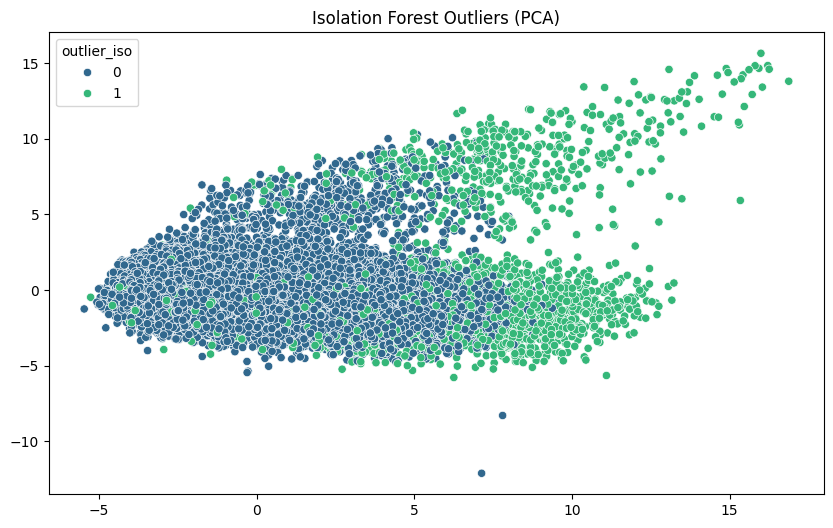

In [225]:
from sklearn.ensemble import IsolationForest

iso_df = df.copy()
X = iso_df.drop(columns=['loan_status'] + list(period_columns))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(contamination=0.05, random_state=0)
outliers_iso = iso_forest.fit_predict(X_scaled)

# Flag outliers (-1 for outliers, 1 for inliers)
iso_df['outlier_iso'] = np.where(outliers_iso == -1, 1, 0)

# Visualize outliers using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=iso_df['outlier_iso'], palette='viridis')
plt.title('Isolation Forest Outliers (PCA)')
plt.show()

In [226]:
iso_df['outlier_iso'].value_counts()

outlier_iso
0    36956
1     1946
Name: count, dtype: int64

In [227]:
iso_df = iso_df[iso_df['outlier_iso'] != 1]
iso_df.reset_index(drop=True, inplace=True)

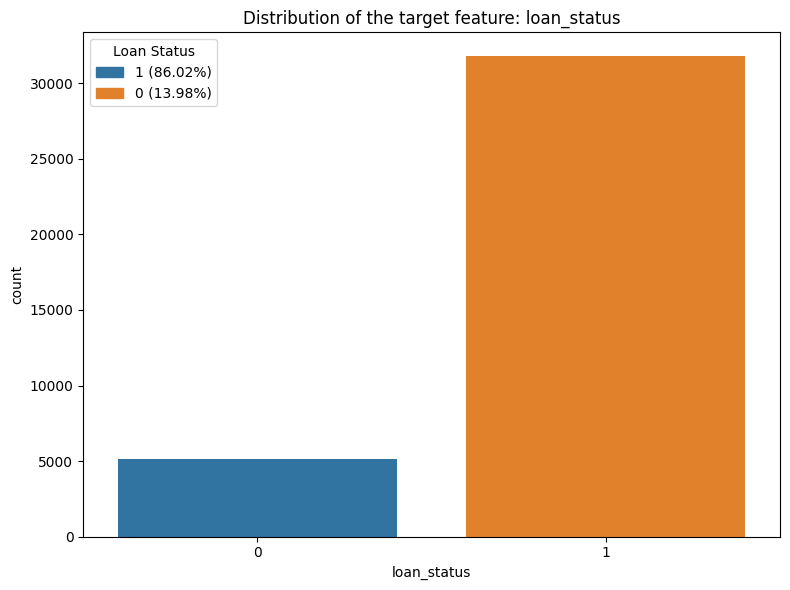

In [228]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=iso_df, x='loan_status',
                   hue='loan_status', legend=False)

# Create handles (use the bars' colors) and labels
target_classes = iso_df['loan_status'].unique()
percentages = iso_df['loan_status'].value_counts(
    normalize=True).loc[target_classes] * 100
handles = [plt.Rectangle((0, 0), 1, 1, color=bar.get_facecolor())
           for bar in ax.patches]
labels = [f"{cls} ({percentages[cls]:.2f}%)" for cls in target_classes]

plt.legend(handles, labels, title='Loan Status')
plt.title('Distribution of the target feature: loan_status')
plt.tight_layout()
plt.show()

### Train - Test Split

In [229]:
period_columns = df.select_dtypes(include=['period[M]']).columns
X = iso_df.drop(columns=['loan_status', 'outlier_iso'] + list(period_columns))
y = iso_df['loan_status']

In [230]:
TRAIN_SIZE = 0.8

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=TRAIN_SIZE, random_state=0)

In [231]:
X_train.shape, X_valid.shape, X_test.shape

((23651, 46), (5913, 46), (7392, 46))

### Normalization

In [232]:
df.describe().T.map('{:.2f}'.format)

count      mean       std      min  \
loan_amnt                            38902.00  11255.19   7471.53   500.00   
funded_amnt                          38902.00  10980.03   7198.86   500.00   
funded_amnt_inv                      38902.00  10555.81   7103.75     0.00   
term                                 38902.00      0.27      0.45     0.00   
int_rate                             38902.00      0.12      0.04     0.05   
installment                          38902.00    324.93    208.81    16.08   
sub_grade                            38902.00      9.92      6.81     0.00   
emp_length                           38902.00      4.19      3.37     0.00   
annual_inc                           38902.00  69027.27  63189.50  4000.00   
loan_status                          38902.00      0.86      0.35     0.00   
purpose                              38902.00      0.47      0.50     0.00   
dti                                  38902.00     13.37      6.67     0.00   
delinq_2yrs                          38902.00      0.15      0.49     0.00   
inq_last_6mths                       38902.00      0.87      1.07     0.00   
open_acc                             38902.00      9.30      4.38     2.00   
pub_rec                              38902.00      0.06      0.24     0.00   
revol_bal                            38902.00  13404.47  15848.89     0.00   
revol_util                           38902.00      0.49      0.28     0.00   
total_acc                            38902.00     22.17     11.39     2.00   
out_prncp                            38902.00     52.30    379.01     0.00   
out_prncp_inv                        38902.00     52.06    377.65     0.00   
total_pymnt                          38902.00  12219.38   9068.26    33.73   
total_pymnt_inv                      38902.00  11758.33   8929.63     0.00   
total_rec_prncp                      38902.00   9840.46   7078.30     0.00   
total_rec_int                        38902.00   2283.49   2626.07     6.22   
total_rec_late_fee                   38902.00      1.33      7.14     0.00   
last_pymnt_amnt                      38902.00   2706.32   4468.58     0.01   
next_pymnt_d                         38902.00      0.03      0.17     0.00   
pub_rec_bankruptcies                 38902.00      0.04      0.20     0.00   
earliest_cr_line_year                38902.00   1996.80      7.41  1969.00   
earliest_cr_line_month               38902.00      6.89      3.54     1.00   
issue_d_year                         38902.00   2010.38      0.81  2007.00   
issue_d_month                        38902.00      7.22      3.37     1.00   
last_pymnt_d_year                    38902.00   2012.87      1.50  2008.00   
last_pymnt_d_month                   38902.00      6.46      3.42     1.00   
last_credit_pull_d_year              38902.00   2014.33      1.74  2007.00   
last_credit_pull_d_month             38902.00      5.82      3.02     1.00   
verification_status_Not Verified     38902.00      0.42      0.49     0.00   
verification_status_Source Verified  38902.00      0.26      0.44     0.00   
verification_status_Verified         38902.00      0.33      0.47     0.00   
home_ownership_MORTGAGE              38902.00      0.45      0.50     0.00   
home_ownership_OTHER_new             38902.00      0.08      0.27     0.00   
home_ownership_RENT                  38902.00      0.47      0.50     0.00   
region_Midwest                       38902.00      0.14      0.35     0.00   
region_Northeast                     38902.00      0.24      0.43     0.00   
region_South                         38902.00      0.33      0.47     0.00   
region_West                          38902.00      0.29      0.45     0.00   

                                          25%       50%       75%         max  
loan_amnt                             5500.00  10000.00  15000.00    35000.00  
funded_amnt                           5500.00   9750.00  15000.00    35000.00  
funded_amnt_inv                       5000.00   9000.00

Since the features are in different value ranges, we will normalize them to bring them closer together - which helps these features have equal influence and makes it easier for the model to converge.

In [233]:
scaler = StandardScaler()

scaler.fit(X_train)
for dataframe in [X_train, X_valid, X_test]:
    scaled_values = scaler.transform(dataframe)
    scaled_df = pd.DataFrame(
        scaled_values, columns=dataframe.columns, index=dataframe.index)
    dataframe = scaled_df

## 4. Model Development

### Compare with Baseline Models

**Logistic Regression**

In [234]:
start_time = time.time()

lr_model = LogisticRegression(solver='saga', max_iter=10000)
lr_model.fit(X_train, y_train)

end_time = time.time()
lr_train_time = end_time - start_time

In [235]:
y_pred_lr = lr_model.predict(X_test)

In [236]:
print("AUC-ROC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr))
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

AUC-ROC (Logistic Regression): 0.8888354120195424
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      1063
           1       0.96      1.00      0.98      6329

    accuracy                           0.97      7392
   macro avg       0.98      0.89      0.93      7392
weighted avg       0.97      0.97      0.97      7392



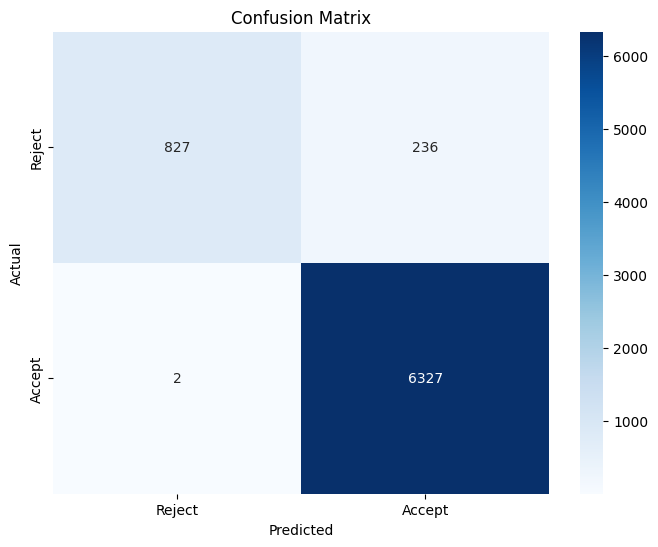

In [237]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Decision Tree**

In [238]:
start_time = time.time()

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

end_time = time.time()
dt_train_time = end_time - start_time

In [239]:
y_pred_dt = dt_model.predict(X_test)

In [240]:
print("AUC-ROC (Decision Tree):", roc_auc_score(y_test, y_pred_dt))
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

AUC-ROC (Decision Tree): 0.9439753575018724
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1063
           1       0.98      0.99      0.99      6329

    accuracy                           0.97      7392
   macro avg       0.95      0.94      0.95      7392
weighted avg       0.97      0.97      0.97      7392



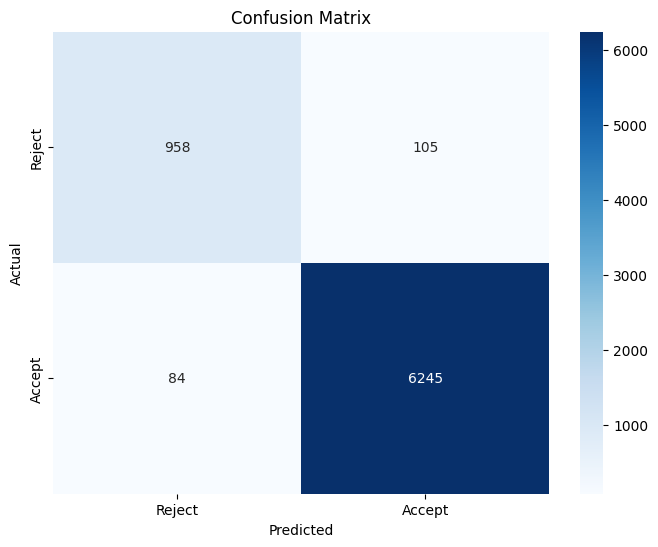

In [241]:
conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Gradient Boosting**

In [242]:
X_train_gbm = X_train
X_valid_gbm = X_valid
X_test_gbm = X_test

categorical_features = cat_cols.copy()
categorical_features.append('emp_length')

for col in categorical_features:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in categorical_features:
    X_valid_gbm[col] = X_valid_gbm[col].astype('category')

for col in categorical_features:
    X_test_gbm[col] = X_test_gbm[col].astype('category')

lgb_train = lgb.Dataset(
    X_train_gbm, y_train,
    categorical_feature=categorical_features,
    free_raw_data=False,
)

lgb_valid = lgb.Dataset(
    X_valid_gbm, y_valid,
    categorical_feature=categorical_features,
    free_raw_data=False,
    reference=lgb_train,
)

params = {
    "objective": "binary",
    "num_iterations": 3000,
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "max_depth": 4,
    "num_threads": 4,
    "tree_learner": "serial",
    # "lambda_l2": 0.05,
    # "path_smooth": 128,
    "early_stopping_round": 200,
    "feature_pre_filter": False,
    "first_metric_only": True,
    "is_unbalance": False,
}

In [243]:
start_time = time.time()

gbm_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(100, first_metric_only=True),
        lgb.log_evaluation(50, show_stdv=True)
    ]
)

end_time = time.time()
gbm_train_time = end_time - start_time

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20349, number of negative: 3302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4369
[LightGBM] [Info] Number of data points in the train set: 23651, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.860386 -> initscore=1.818503
[LightGBM] [Info] Start training from score 1.818503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [244]:
y_pred = gbm_model.predict(X_test_gbm)
y_pred_gbm = (y_pred > 0.5).astype(int)

In [ ]:
print("AUC-ROC (Gradient Boosting/LightGBM):",
      roc_auc_score(y_test, y_pred_gbm))
print("Gradient Boosting/LightGBM - Classification Report:")
print(classification_report(y_test, y_pred_gbm))

AUC-ROC (Gradient Boosting/LightGBM): 0.9905926622765757
Gradient Boosting/LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1063
           1       1.00      1.00      1.00      6329

    accuracy                           1.00      7392
   macro avg       1.00      0.99      0.99      7392
weighted avg       1.00      1.00      1.00      7392



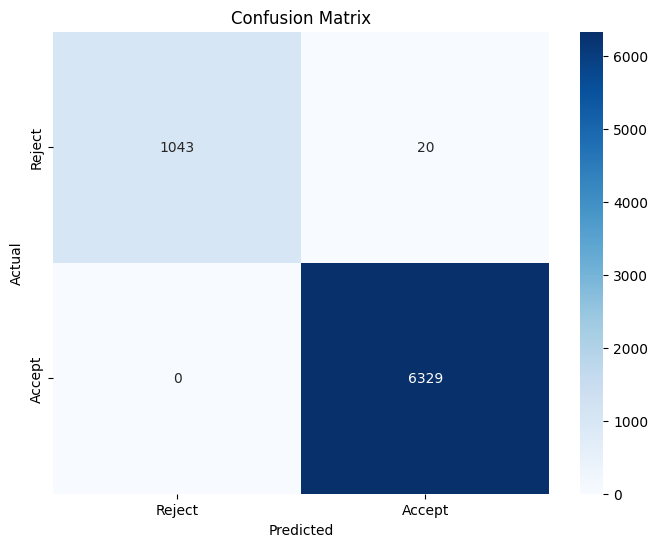

In [246]:
conf_matrix = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Comparison**

In [247]:
metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_gbm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_pred_gbm),
    ],
    'Train Time': [
        lr_train_time,
        dt_train_time,
        gbm_train_time,
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0  Logistic Regression  0.967803   0.968865  0.967803  0.966104  0.888835   
1        Decision Tree  0.974432   0.974250  0.974432  0.974325  0.943975   
2    Gradient Boosting  0.997294   0.997303  0.997294  0.997284  0.990593   

   Train Time  
0   59.276402  
1    0.609513  
2    3.287057

**Initial Observations:**

*  All 3 models performed worse before handling the outliers. This indicates that the outliers we just removed were necessary for this problem.

⇒ We will no longer handle outliers and will just add class weights to the baseline models.

### Imbalance handled Models

In [248]:
X = df.drop(columns=['loan_status'] + list(period_columns))
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=TRAIN_SIZE, random_state=0)

scaler = StandardScaler()

scaler.fit(X_train)
for dataframe in [X_train, X_valid, X_test]:
    scaled_values = scaler.transform(dataframe)
    scaled_df = pd.DataFrame(
        scaled_values, columns=dataframe.columns, index=dataframe.index)
    dataframe = scaled_df

**Logistic Regression**

In [249]:
start_time = time.time()

lr_model = LogisticRegression(
    solver='saga', max_iter=10000, class_weight='balanced')
lr_model.fit(X_train, y_train)

end_time = time.time()
lr_train_time = end_time - start_time

print(f"Training time: {lr_train_time:.2f} seconds")
y_pred_lr = lr_model.predict(X_test)

Training time: 57.54 seconds


In [250]:
print("AUC-ROC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr))
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

AUC-ROC (Logistic Regression): 0.9685129458253802
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1120
           1       0.99      1.00      0.99      6661

    accuracy                           0.99      7781
   macro avg       0.99      0.97      0.98      7781
weighted avg       0.99      0.99      0.99      7781



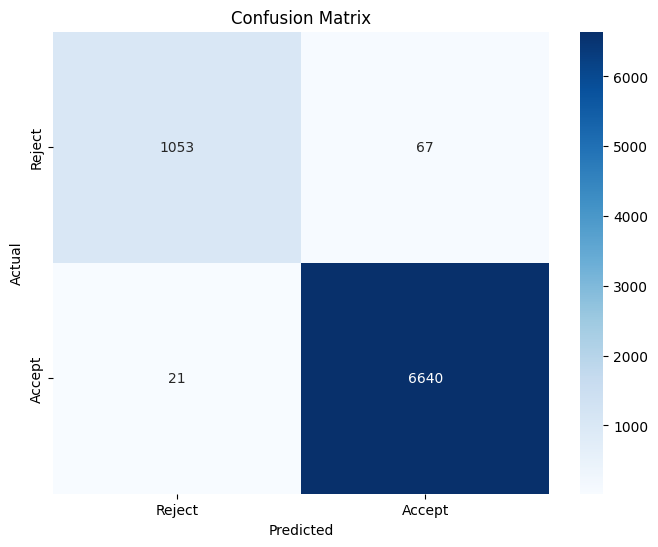

In [251]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Decision Tree**

In [252]:
start_time = time.time()

dt_model = DecisionTreeClassifier(class_weight='balanced')
dt_model.fit(X_train, y_train)

end_time = time.time()
dt_train_time = end_time - start_time

print(f"Training time: {dt_train_time:.2f} seconds")
y_pred_dt = dt_model.predict(X_test)

Training time: 0.52 seconds


In [253]:
print("AUC-ROC (Decision Tree):", roc_auc_score(y_test, y_pred_dt))
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

AUC-ROC (Decision Tree): 0.9784726392433569
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1120
           1       0.99      0.99      0.99      6661

    accuracy                           0.99      7781
   macro avg       0.98      0.98      0.98      7781
weighted avg       0.99      0.99      0.99      7781



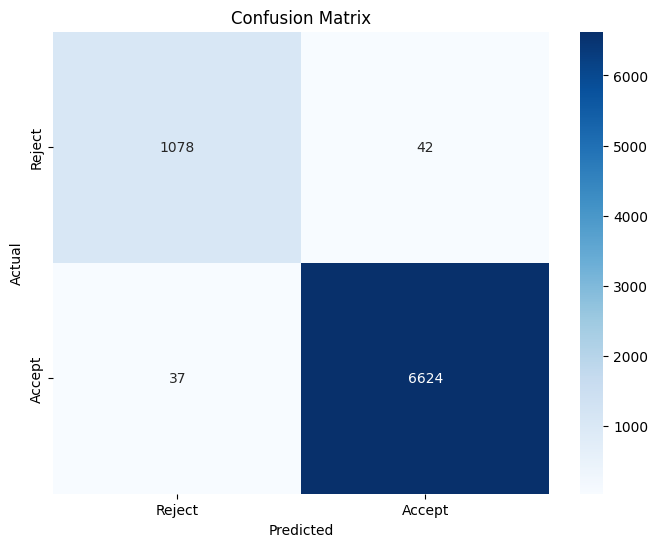

In [254]:
conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**LightGBM**

In [255]:
X_train_gbm = X_train
X_valid_gbm = X_valid
X_test_gbm = X_test

cat_cols, num_cols, cat_but_car = grab_col_names(
    baseline_X, cat_th=5, car_th=10)
categorical_features = cat_cols.copy()
categorical_features.append('emp_length')

for col in categorical_features:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in categorical_features:
    X_valid_gbm[col] = X_valid_gbm[col].astype('category')

for col in categorical_features:
    X_test_gbm[col] = X_test_gbm[col].astype('category')

lgb_train = lgb.Dataset(
    X_train_gbm, y_train,
    categorical_feature=categorical_features,
    free_raw_data=False,
)

lgb_valid = lgb.Dataset(
    X_valid_gbm, y_valid,
    categorical_feature=categorical_features,
    free_raw_data=False,
    reference=lgb_train,
)

params = {
    "objective": "binary",
    "num_iterations": 3000,
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "max_depth": 4,
    "num_threads": 4,
    "tree_learner": "serial",
    # "lambda_l2": 0.05,
    # "path_smooth": 128,
    "early_stopping_round": 200,
    "feature_pre_filter": False,
    "first_metric_only": True,
    "is_unbalance": True,  # Set to True for class imbalance
}

# of Observations: 38902
# of Features: 46
# of Categorical Columns: 14	(Numerical but categorical: 14)
# of Numerical Columns: 32
# of Categorical but cardinal: 0


In [256]:
start_time = time.time()

gbm_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(100, first_metric_only=True),
        lgb.log_evaluation(50, show_stdv=True)
    ]
)

end_time = time.time()
gbm_train_time = end_time - start_time

print(f"Training time: {gbm_train_time:.2f} seconds")
y_pred = gbm_model.predict(X_test_gbm)
y_pred_gbm = (y_pred > 0.5).astype(int)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21450, number of negative: 3446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 24896, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.861584 -> initscore=1.828511
[LightGBM] [Info] Start training from score 1.828511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
print("AUC-ROC (Gradient Boosting/LightGBM):",
      roc_auc_score(y_test, y_pred_gbm))
print("Gradient Boosting/LightGBM - Classification Report:")
print(classification_report(y_test, y_pred_gbm))

AUC-ROC (Gradient Boosting/LightGBM): 0.992260586677247
Gradient Boosting/LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1120
           1       1.00      1.00      1.00      6661

    accuracy                           1.00      7781
   macro avg       1.00      0.99      1.00      7781
weighted avg       1.00      1.00      1.00      7781



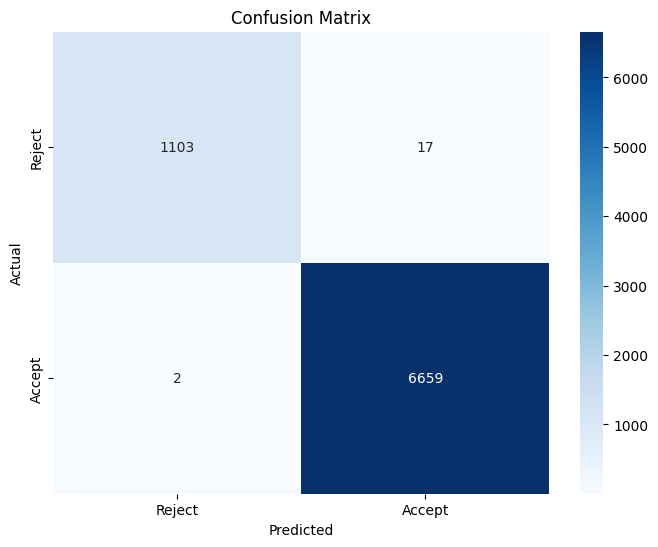

In [258]:
conf_matrix = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Comparison**

In [259]:
metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_gbm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_pred_gbm),
    ],
    'Train Time': [
        lr_train_time,
        dt_train_time,
        gbm_train_time,
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0  Logistic Regression  0.988690   0.988634  0.988690  0.988591  0.968513   
1        Decision Tree  0.989847   0.989830  0.989847  0.989838  0.978473   
2    Gradient Boosting  0.997558   0.997560  0.997558  0.997551  0.992261   

   Train Time  
0   57.538038  
1    0.521277  
2    2.989855

**Initial Observations:**

*  Adding class weights to the models showed a clear improvement, especially for Logistic Regression, where the `Recall` for the `Reject` class increased from 0.8 to 0.94 — a significant jump.

*  Although there was a clear improvement, the Logistic Regression model still lagged behind the other two models in terms of metrics, training time, and even explainability.

*  The Decision Tree and LightGBM (Gradient Boosting) models showed similar results, with LightGBM performing slightly better. However, Decision Tree offers much higher interpretability compared to LightGBM (which, being a boosting model, is composed of many trees). The Decision Tree's explanations can also be easily extracted into rules and are easily plotted and read by humans.

⇒ Depending on the purpose of the task — whether prioritizing Explainability/Interpretability or prioritizing predictive accuracy — we will select the appropriate model.

⇒ In this case, since we treat the problem as building a predictive model to support banks in convincing investors to lend, we need to prioritize explainability so that investors can understand why a loan is considered safe and worth investing in, and why a loan is considered risky and likely to be charged off.

⇒ We choose the Decision Tree model, and then simplify and hyper-tune it to make it suitable for real-world deployment.

## 5. Model Explainability

**Logistic Regression**

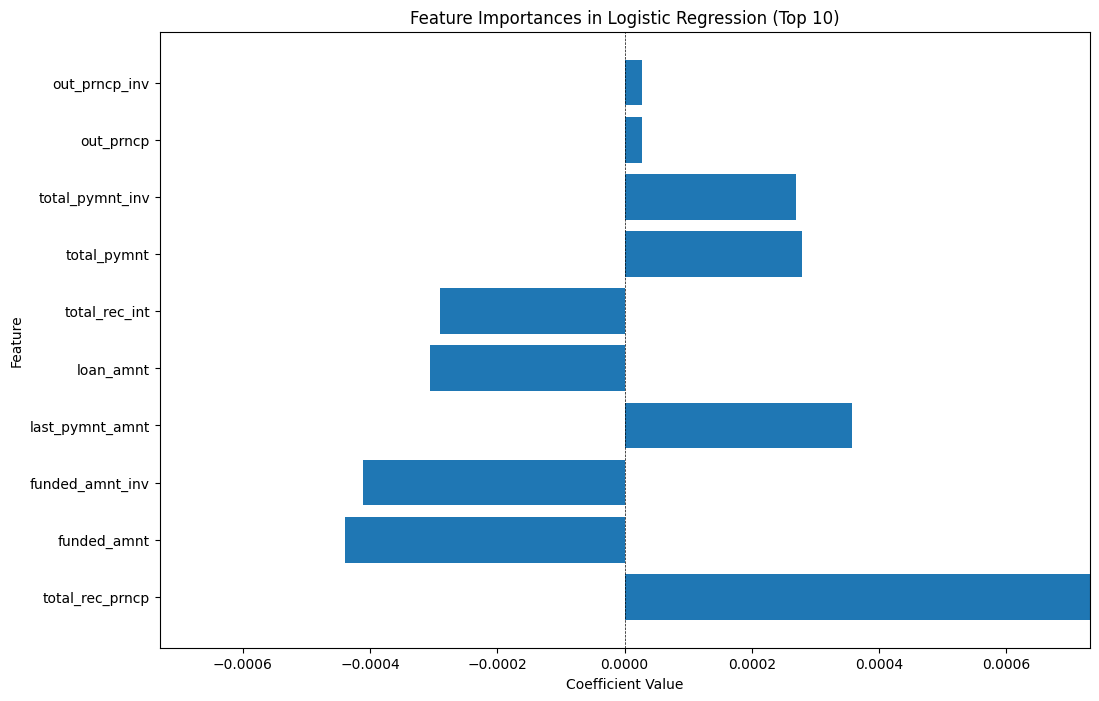

In [260]:
coefficients = lr_model.coef_[0]  # Access coefficients for feature importance
feature_names = X_train.columns

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort by absolute value of coefficient to get the most important features
feature_importance['Abs Coefficient'] = np.abs(
    feature_importance['Coefficient'])
feature_importance_sorted = feature_importance.sort_values(
    by='Abs Coefficient', ascending=False)

# Plotting the feature importances (Coefficients)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_sorted['Feature'].head(
    10), feature_importance_sorted['Coefficient'].head(10))
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Set symmetric x-axis limits
max_corr = feature_importance_sorted['Coefficient'].abs().max()
plt.xlim(-max_corr, max_corr)

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances in Logistic Regression (Top 10)')
plt.show()

**Decision Tree**

In [261]:
importances = dt_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

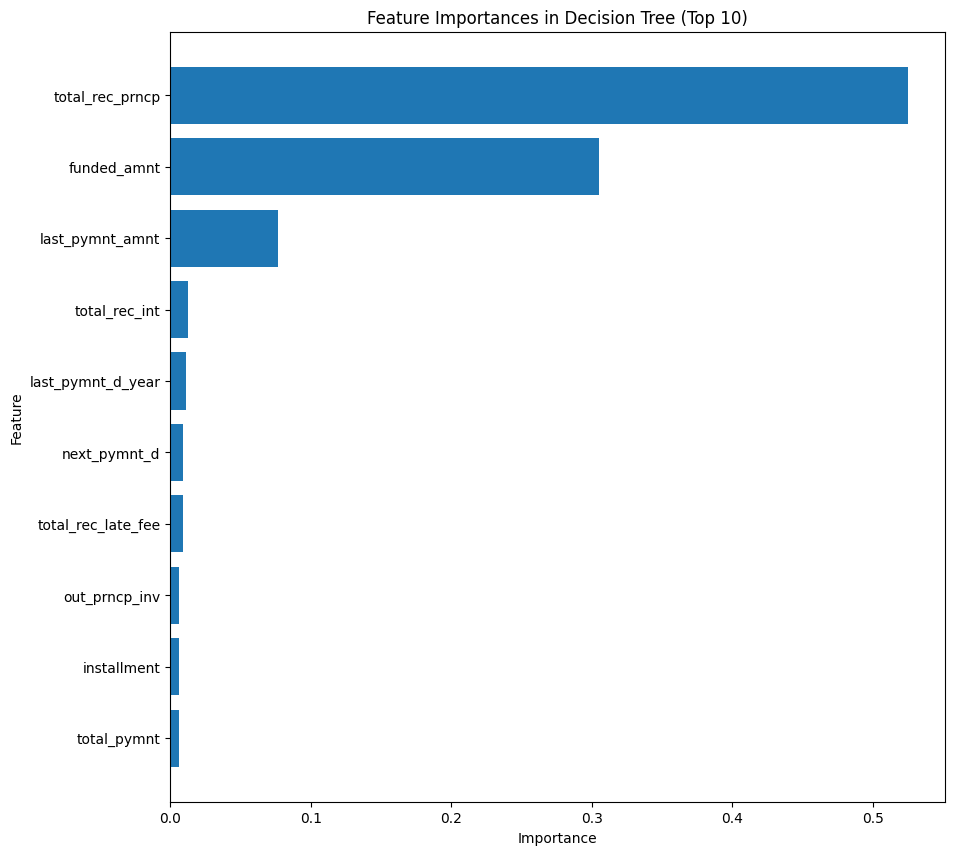

In [262]:
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'].tail(10),
         importance_df['Importance'].tail(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree (Top 10)')
plt.show()

**Gradient Boosting (LightGBM)**

c:\Users\PC\anaconda3\envs\loan\lib\site-packages\shap\explainers\_tree.py:583: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



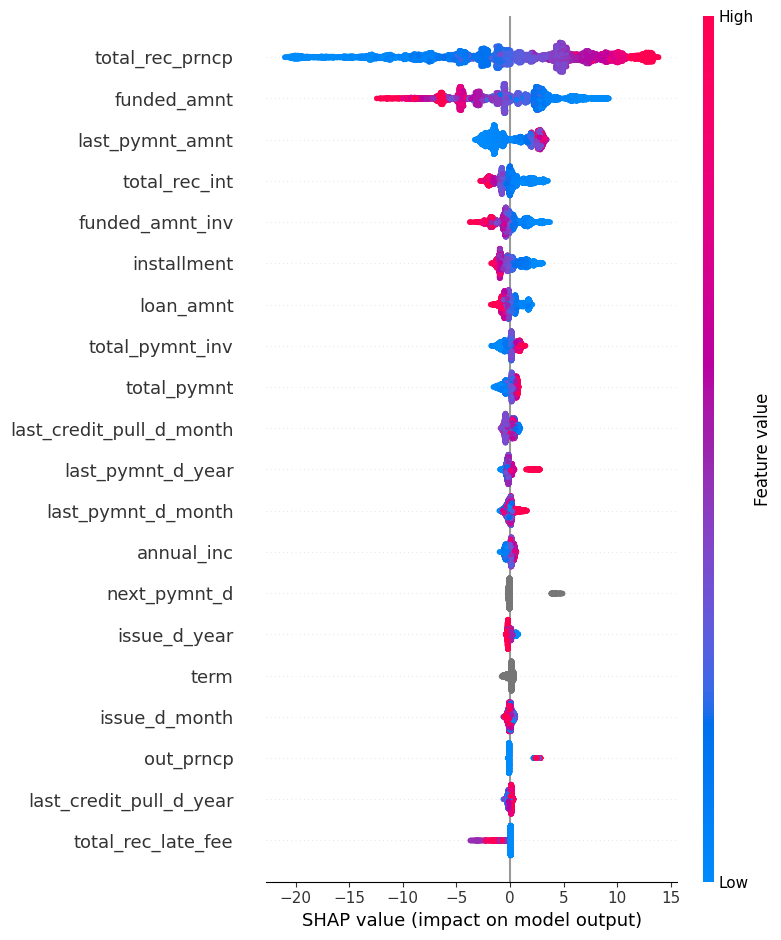

In [263]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(X_valid_gbm)

shap.summary_plot(shap_values, X_valid_gbm)

**Initial Observations:**

*  In the **Logistic Regression** model, the features with the strongest impact are:
    *  `total_rec_prncp`: Has a strong positive coefficient, indicating that the higher the amount of principal repaid, the higher the probability of loan approval. This makes sense in practice, as borrowers who have repaid more tend to have better creditworthiness and a higher chance of getting approved for additional loans.
    *  `funded_amnt` và `funded_amnt_inv`: These 2 features have the largest negative coefficients, suggesting that as the amount funded (funded_amnt) and the amount funded by investors (funded_amnt_inv) increase, the likelihood of loan approval decreases. This aligns with reality, as larger loan amounts are typically harder to get approved.
    *  The features `last_pymnt_amnt`, `loan_amnt`, `total_rec_int`, `total_pymnt` and `total_pymnt_inv` have gradually decreasing coefficient magnitudes. While not as large, they are still significantly more influential than the features that follow.

*  In the **Decision Tree** model, the features with the strongest impact are:
    *  `total_rec_prncp`: The most important feature, with a much greater influence than the others. This matches practical expectations and aligns with the findings from Logistic Regression.
    *  `funded_amnt`: The second most important feature, indicating that the total amount funded has a substantial effect on predictions. This also aligns with reality and the Logistic Regression results.
    *  `last_pymnt_amnt`: The third most important feature. Although its Feature Importance is significantly lower than the top two, it is still noticeably higher than that of the remaining features, suggesting that the last payment amount does have some impact on the prediction.

*  In the **Gradient Boosting (LightGBM)** model, the features with the strongest impact are:
    *  `total_rec_prncp`: The most important feature. The SHAP values in red are all positive, meaning the larger the principal repaid, the higher the likelihood of loan approval. This finding matches practical expectations and is consistent with the Logistic Regression analysis.
    *  `funded_amnt`: The second most important feature. The SHAP values in red are negative, indicating that a larger funded amount corresponds to a lower probability of loan approval. This observation is also consistent with the earlier analysis in Logistic Regression.
    *  `last_pymnt_amnt`: The third most important feature. The red SHAP values are positive, meaning the larger the most recent payment amount, the higher the probability of loan approval. This is logical because higher recent payments suggest stronger repayment ability, leading to higher approval rates.

Overall, the features that consistently have the strongest impact across all three models are `funded_amnt` (amount funded/requested), `total_rec_prncp` (principal repaid), and `last_pymnt_amnt` (last payment amount). In practice, these 3 factors also play a major role in lending decisions, meaning the trained models have produced reasonable and explainable results that align with reality.

Additionally, to build a simpler new model, we previously chose the Decision Tree model. Therefore, we will now select the 3 most influential features from the Decision Tree — `total_rec_prncp`, `funded_amnt`, and `last_pymnt_amnt` — to train the new model.

## 6. Building a Simplier New Model

**Create a new dataset containing only the 3 selected features and the target variable.**

In [264]:
new_df = pd.DataFrame()

for feature in importance_df['Feature'].tail(3):
    new_df[feature] = df[feature]

new_df['loan_status'] = df['loan_status']

In [265]:
new_df

last_pymnt_amnt  funded_amnt  total_rec_prncp  loan_status
0               171.62         5000          5000.00            1
1               119.66         2500           456.46            0
2               649.91         2400          2400.00            1
3               357.48        10000         10000.00            1
4                67.79         3000          2475.94            1
...                ...          ...              ...          ...
39562          3891.08         4800          4800.00            1
39573          1571.29         7000          7000.00            1
39623           301.05         9000          1496.83            0
39666          1016.15        15450          8688.59            0
39680           101.51         3000          3000.00            1

[38902 rows x 4 columns]

**Train-Test split & Normalization**

In [266]:
X_new = new_df.drop(columns=['loan_status'])
y_new = new_df['loan_status']

In [267]:
TRAIN_SIZE = 0.8

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, train_size=TRAIN_SIZE, random_state=0)

In [268]:
X_train_new.shape, X_test_new.shape

((31121, 3), (7781, 3))

**Train & Hypertune the model**

Using Pipeline to hypertune with GridSearchCV for simplicity.

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[("scaler", StandardScaler()),

                       ("tree", DecisionTreeClassifier(class_weight='balanced', random_state=0))])


param_grid = {

    "tree__criterion": ["gini", "entropy", "log_loss"],

    "tree__max_depth": [None, 5, 10, 20],

    "tree__min_samples_split": [2, 5, 10],

    "tree__min_samples_leaf": [1, 2, 4],

    "tree__max_features": [None, "sqrt", "log2"]

}


search = GridSearchCV(pipe, param_grid, scoring="roc_auc", n_jobs=-1)

search.fit(X_train_new, y_train_new)

best_model = search.best_estimator_

tree_model = best_model.named_steps["tree"]

scaler = best_model.named_steps["scaler"]

print("Best parameter (CV score=%0.3f):" % search.best_score_)

print(search.best_params_)

Best parameter (CV score=0.990):
{'tree__criterion': 'entropy', 'tree__max_depth': 10, 'tree__max_features': None, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 10}


**Evaluate the New Model**

In [270]:
# Measure performance of the model
predicted_label = search.predict(X_test_new)
print("AUC-ROC (Finetuned):", roc_auc_score(y_test_new, predicted_label))
print("Classification report: \n", classification_report(
    y_test_new, predicted_label, digits=3))

AUC-ROC (Finetuned): 0.9840352022433353
Classification report: 
               precision    recall  f1-score   support

           0      0.945     0.978     0.961      1120
           1      0.996     0.990     0.993      6661

    accuracy                          0.989      7781
   macro avg      0.971     0.984     0.977      7781
weighted avg      0.989     0.989     0.989      7781



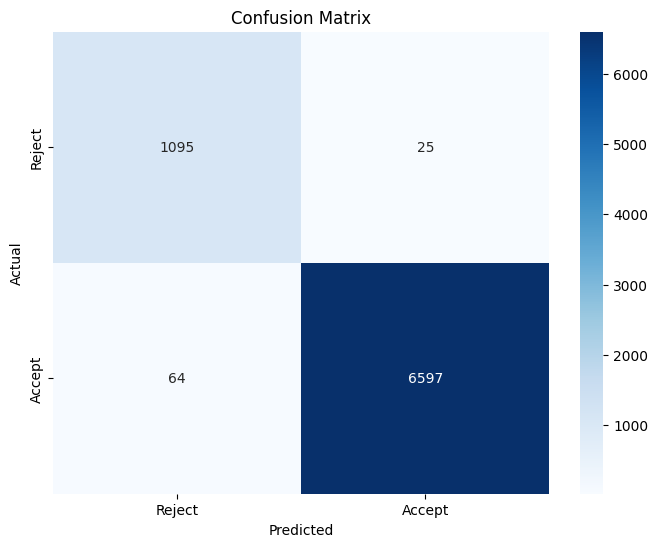

In [271]:
conf_matrix = confusion_matrix(y_test_new, predicted_label)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We can extract rules as reasoning for the model’s prediction results by plotting the Decision Tree as follows. (Here, only the top 3 layers are plotted to ensure the content of the nodes is readable).

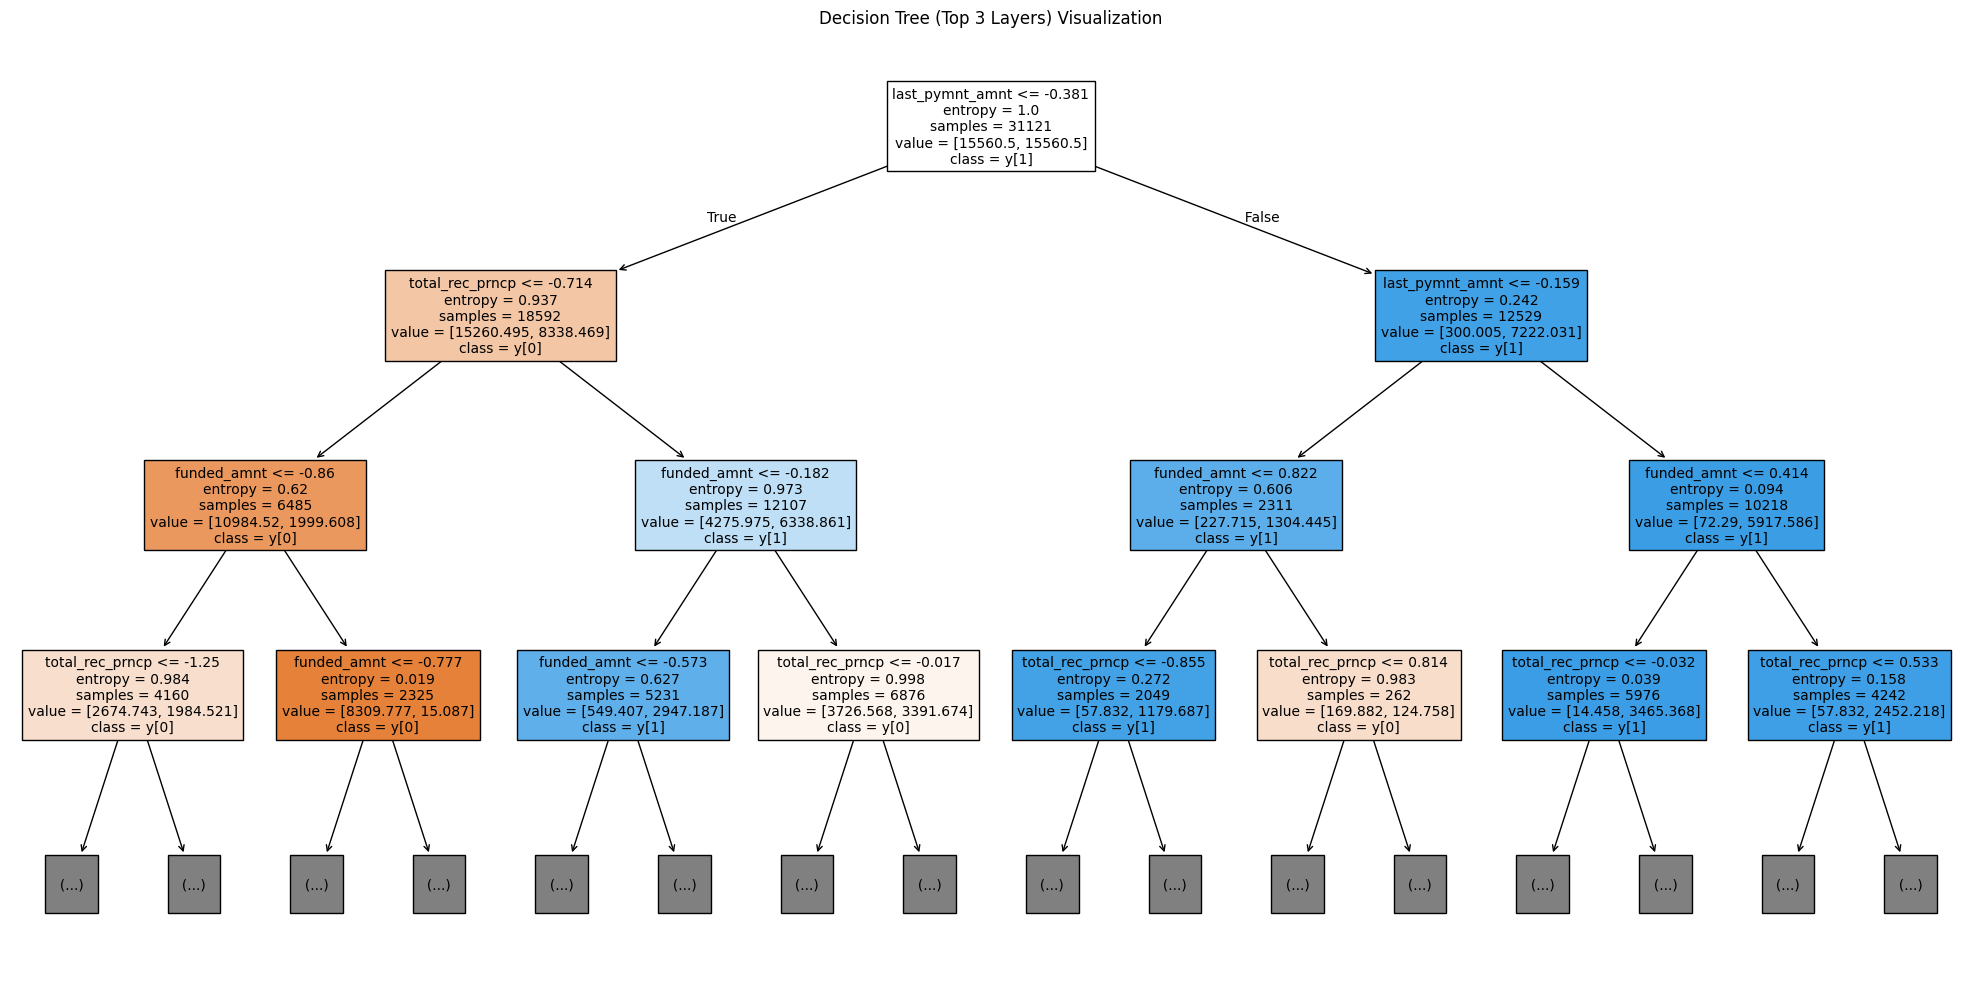

In [272]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=X_new.columns,
          class_names=True,
          filled=True,
          max_depth=3,  # Only show top 3 layers
          fontsize=10)
plt.title('Decision Tree (Top 3 Layers) Visualization')
plt.tight_layout()
plt.show()

**Compare the original model with the simplified model**

In [273]:
metrics = {
    'Model': ['Decision Tree', 'Tuned Decision Tree (3 Features)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test_new, predicted_label),
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test_new, predicted_label, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test_new, predicted_label, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test_new, predicted_label, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test_new, predicted_label),
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score  \
0                     Decision Tree  0.989847    0.98983  0.989847  0.989838   
1  Tuned Decision Tree (3 Features)  0.988562    0.98882  0.988562  0.988643   

    AUC-ROC  
0  0.978473  
1  0.984035

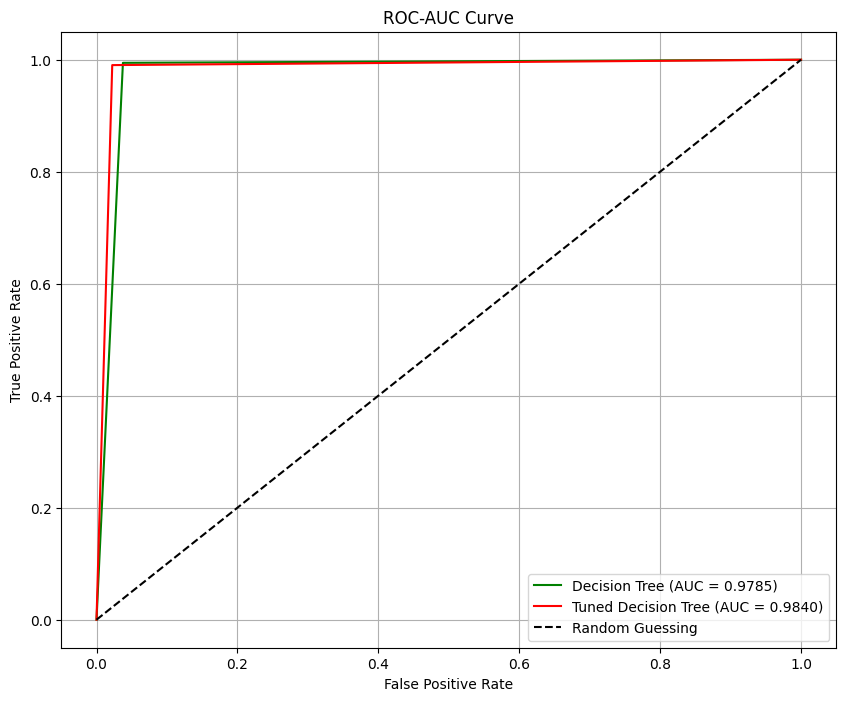

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC-AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# ROC-AUC for Tuned Decision Tree with 3 features
fpr_new, tpr_new, _ = roc_curve(y_test_new, predicted_label)
roc_auc_new = auc(fpr_new, tpr_new)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt,
         label=f'Decision Tree (AUC = {roc_auc_dt:.4f})', color='green')
plt.plot(fpr_new, tpr_new,
         label=f'Tuned Decision Tree (AUC = {roc_auc_new:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Initial Observations:**

*  The new model only performs about 0.001 points worse than the old Decision Tree model in terms of Accuracy, Precision, Recall, and F1 Score, but it outperforms it significantly in the AUC metric (higher by ~0.005). This means that the new Decision Tree model has better classification ability than the old Decision Tree model. (The reason we chose AUC for comparison is that AUC is particularly useful in cases of imbalanced data, as it is not dependent on a fixed classification threshold).

⇒ Even though the new model uses only 3 features for prediction, after hypertuning, its performance is not inferior to the Decision Tree model trained with 46 features and even outperforms it in the AUC metric.

⇒ Given the simplicity and effectiveness of the model, it can definitely be applied in practice. Additionally, we can extract rules (like the tree plotted above) to explain the model's results.

**Save the scaler and model's parameters**

In [275]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [276]:
model_pkl_file = "loan_classifier_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(tree_model, file)